# 0. Import Package and Configration

In [1]:
import scipy.stats as stats
from scipy.stats import ks_2samp
from shapely.geometry import shape
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib import gridspec
from urllib.parse import quote
import seaborn as sns
import pickle, csv
import numpy as np
import pandas as pd
from compress_pickle import dump as cdump
from compress_pickle import load as cload
import networkx as nx
from multiprocessing import Pool
import numpy as np
import matplotlib.ticker as ticker
import geopandas as gpd
import matplotlib.patches as mpatches
import shapely.geometry as sgeom
import contextily as cx
import random as rand
import scipy as sp
import os
import warnings
import csv, json
from geojson import Feature, FeatureCollection, Point
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.colors as clr
from geopandas import GeoDataFrame
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import numpy as np
import kaleido
from webcolors import hex_to_rgb
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go # Import the graphical object
import plotly.io as pio
warnings.filterwarnings("ignore")

/home/jiaman/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
mode = 1; year= 0
fsize = 12; tdir = 'in'; major = 6; minor = 4; lwidth = 1; lhandle = 1
space_symbol = '                          '
color_platte = ['#00429d', '#4771b2', 
'#73a2c6', '#a5d5d8', '#ffffe0', '#fcc17e', '#e0884e', '#bc4f3c', '#93003a']
plt.style.use('default')
sns.set_theme(style="white")
plt.rcParams['figure.figsize'] = [6.4, 4.8]
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = fsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.labelsize'] = fsize
plt.rcParams['ytick.labelsize'] = fsize
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = True
plt.rcParams.update({'font.family':'Arial'})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_platte) 

In [3]:
colors= ['#001144', '#00245a', '#013871', '#0d4c89', '#305f9e', '#4973b4', '#6087ca', '#779ce1', '#8eb2f9', '#a7caff', '#c1e4ff'][::-1]
nodes = np.arange(0,1.1,0.1)
homecmap = clr.LinearSegmentedColormap.from_list("homecmap", list(zip(nodes, colors)))
colors= ['#001819', '#012b2e', '#0a3e41', '#235255', '#386669', '#4d7b7e', '#639194', '#78a7aa', '#8fbec1', '#a5d5d8', '#bdedf0'][::-1]
nodes = np.arange(0,1.1,0.1)
workcmap = clr.LinearSegmentedColormap.from_list("workcmap", list(zip(nodes, colors)))
colors= ['#310300', '#401a00', '#532d00', '#694001', '#805313', '#976728', '#ae7b3c', '#c69050', '#dea664', '#f7bc79', '#ffd995'][::-1]
nodes = np.arange(0,1.1,0.1)
othercmap = clr.LinearSegmentedColormap.from_list("othercmap", list(zip(nodes, colors)))
colors= ['#440000', '#580000', '#700401', '#892216', '#a23929', '#bc4f3c', '#d66550', '#f17c65', '#ff937b', '#ffab91', '#ffc3a8'][::-1]
nodes = np.arange(0,1.1,0.1)
totalcmap = clr.LinearSegmentedColormap.from_list("totalcmap", list(zip(nodes, colors)))
colors_map = [homecmap,workcmap,othercmap,totalcmap]
colors= ['#001144', '#00245a', '#013871', '#0d4c89', '#305f9e', '#4973b4', '#6087ca', '#779ce1', '#8eb2f9', '#a7caff', '#c1e4ff']
nodes = np.arange(0,1.1,0.1)
bluecmap = clr.LinearSegmentedColormap.from_list("bluecmap", list(zip(nodes, colors)))
colors= ['#440000', '#580000', '#700401', '#892216', '#a23929', '#bc4f3c', '#d66550', '#f17c65', '#ff937b', '#ffab91', '#ffc3a8']
nodes = np.arange(0,1.1,0.1)
redcmap = clr.LinearSegmentedColormap.from_list("redcmap", list(zip(nodes, colors)))

# 1. Current charging supply from Open Charging Map

In [4]:
f_json = open('data/supply/referencedata.json')
data = json.load(f_json)
f_json.close()
row = []
for item in data['UsageTypes']:
    row.append([item['ID'],item['Title']])
info = pd.DataFrame(row, columns = ['ID', 'Title'])    
info['StationType']=['Unknown','Work Charging Places','Work Charging Places','Home Charging Places','Public Charging Places','Public Charging Places','Public Charging Places','Public Charging Places']
info.to_csv("data/supply/usage_type.csv",index=False)   

dataPath_sim = 'data/supply/US/'
simFiles = [dataPath_sim + f for f in os.listdir(dataPath_sim) if os.path.isfile(os.path.join(dataPath_sim, f)) and 'json' in f]
simFiles = sorted(simFiles)
evcs_info = []
evcs_geojson = []
count = 0
for simFile in simFiles:
    f_json = open(simFile)
    data = json.load(f_json)
    f_json.close()
    for i in range(len(data['Connections'])):
        try:
            latitude, longitude = map(float, (data['AddressInfo']['Latitude'], data['AddressInfo']['Longitude']))
        except:
            continue
        try:
            IsRecentlyVerified = data['IsRecentlyVerified']
        except:
            IsRecentlyVerified = None
        try:
            DateLastVerified = data['DateLastVerified']
        except:
            DateLastVerified = None
        try:
            ID = data['ID']
        except:
            ID = None
        try:
            UUID = data['UUID']
        except:
            UUID = None
        try:
            DataProviderID = data['DataProviderID']
        except:
            DataProviderID = None
        try:        
            OperatorsReference = data['OperatorsReference']
        except:
            OperatorsReference = None
        try:
            UsageTypeID = data['UsageTypeID']
        except:
            continue
        try:
            UsageCost = data['UsageCost']
        except:
            UsageCost = None
        try:
            AddressInfoID = data['AddressInfo']['ID']
        except:
            AddressInfoID = None
        try:
            AddressInfoDistanceUnit = data['AddressInfo']['DistanceUnit']
        except:
            AddressInfoDistanceUnit = None
        try:
            AddressInfoTitle = data['AddressInfo']['Title']
        except:
            AddressInfoTitle = None
        try:
            ConnectionID = data['Connections'][i]['ID']
        except:
            ConnectionID = None
        try:
            ConnectionTypeID = data['Connections'][i]['ConnectionTypeID']
        except:
            ConnectionTypeID = None
        try:
            ConnectionStatusTypeID = data['Connections'][i]['StatusTypeID']
        except:
            ConnectionStatusTypeID = None
        try:
            LevelID = data['Connections'][i]['LevelID']
        except:
            LevelID = None
        try:
            Amps =  data['Connections'][i]['Amps']
        except:
            Amps = None
        try:
            Voltage = data['Connections'][i]['Voltage']
        except:
            Voltage = None
        try:
            PowerKW = data['Connections'][i]['PowerKW']
        except:
            continue
        try:
            CurrentTypeID = data['Connections'][i]['CurrentTypeID']
        except:
            CurrentTypeID = None
        try:
            Quantity = data['Connections'][i]['Quantity']
        except:
            continue
        try:
            NumberOfPoints = data['NumberOfPoints']
        except:
            NumberOfPoints = None
        try:
            GeneralComments = data['GeneralComments']
        except:
            GeneralComments = None
        try:
            StatusTypeID = data['StatusTypeID']
        except:
            StatusTypeID = None
        try:
            DateLastStatusUpdate = data['DateLastStatusUpdate']
        except:
            DateLastStatusUpdate = None
        try:
            DataQualityLevel = data['DataQualityLevel']
        except:
            DataQualityLevel = None
        try:
            DateCreated = data['DateCreated']
        except:
            DateCreated = None
        try:
            SubmissionStatusTypeID = data['SubmissionStatusTypeID']
        except:
            SubmissionStatusTypeID = None

        evcs_geojson.append(
        Feature(
            geometry = Point((longitude, latitude)),
            properties = {
                'IsRecentlyVerified': IsRecentlyVerified,
                'DateLastVerified': DateLastVerified,
                'ID':ID,
                'UUID': UUID,
                'DataProviderID':DataProviderID,
                'OperatorsReference':OperatorsReference,
                'UsageTypeID':UsageTypeID,
                'UsageCost':UsageCost,
                'AddressInfoID':AddressInfoID,
                'AddressInfoDistanceUnit':AddressInfoDistanceUnit,
                'AddressInfoTitle':AddressInfoTitle,
                'ConnectionID': ConnectionID,
                'ConnectionTypeID': ConnectionTypeID,
                'ConnectionStatusTypeID': ConnectionStatusTypeID,
                'LevelID': LevelID,
                'PowerKW': PowerKW,     
                'Amps' :  Amps,
                'Voltage' : Voltage,
                'CurrentTypeID':CurrentTypeID,
                'Quantity': Quantity,
                'NumberOfPoints':NumberOfPoints,
                'GeneralComments':GeneralComments,
                'StatusTypeID':StatusTypeID,
                'DateLastStatusUpdate': DateLastStatusUpdate,
                'DataQualityLevel': DataQualityLevel,
                'DateCreated': DateCreated,
                'SubmissionStatusTypeID': SubmissionStatusTypeID
                }
            )
        )

collection = FeatureCollection(evcs_geojson)
with open("data/supply/evcs.geojson", "w") as f:
    f.write('%s' % collection)

In [55]:
info = pd.read_csv('data/supply/usage_type.csv')
geozip = gpd.read_file("data/census/sfbay_zip.geojson")
geocs = gpd.read_file("data/supply/evcs.geojson")
geocounty = gpd.read_file("data/census/Bay Area Counties.geojson")

geocs['UsageTypeID'] = geocs['UsageTypeID'].astype(int)
geocs = geocs.merge(info,left_on='UsageTypeID',right_on='ID')
evcs_sfbay = gpd.sjoin(geozip,geocs,how="inner")
evcs_sfbay['Power'] = evcs_sfbay['PowerKW'] * evcs_sfbay['Quantity']
evcs_sfbay = evcs_sfbay[evcs_sfbay['StationType']=='Public Charging Places']
evcs_sfbay_power = pd.pivot_table(evcs_sfbay, values='Power', index=['ZCTA5CE10'],aggfunc=np.sum)

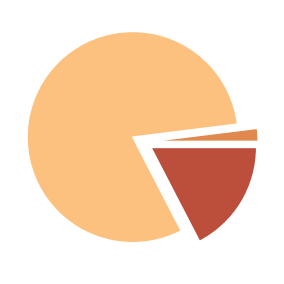

In [6]:
evcs_sfbay_vis = pd.pivot_table(evcs_sfbay, values='Quantity',columns=['LevelID'], index=['ZCTA5CE10'],aggfunc=np.sum)
evcs_sfbay_vis = np.sum(evcs_sfbay_vis,axis=0)
evcs_sfbay_vis = evcs_sfbay_vis.rename(index={1: "Level 1", 2: "Level 2", 3: "Level 3"})

fig, ax = plt.subplots(figsize=(3,3))
wedges, texts, autotexts = ax.pie(evcs_sfbay_vis.values,colors=[ '#e0884e','#fcc17e', '#bc4f3c'], explode=(0.1,0.1,0.1),autopct=' ',textprops=dict(color="k"))

# ax.legend(wedges, evcs_sfbay_vis.index,
#           loc="center left", frameon=False,
#           bbox_to_anchor=(1, 0, 0.5, 1),fontsize=15)

plt.tight_layout()
plt.savefig('figures/fig3_pie_station.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

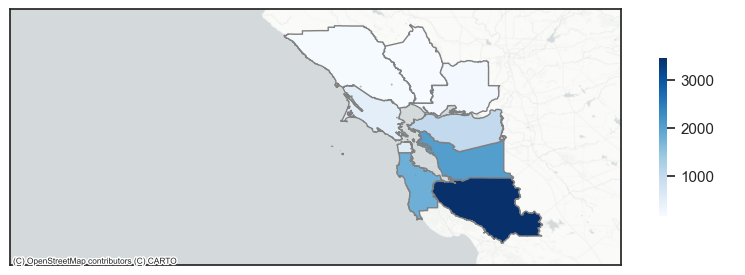

In [92]:
evcs_sfbay_vis = pd.pivot_table(evcs_sfbay, values='Quantity', index=['ZCTA5CE10'],aggfunc=np.sum).reset_index()
geozip_merge = geozip.merge(evcs_sfbay_vis,right_on='ZCTA5CE10',left_on='ZCTA5CE10', how='left')
geozip_merge = gpd.sjoin(geozip_merge,geocounty)
geozip_merge = pd.pivot_table(geozip_merge, values=['Quantity'], index=['county'], aggfunc=np.sum).reset_index()
geozip_merge = GeoDataFrame(geozip_merge.merge(geocounty,right_on='county',left_on='county', how='left'))

fig, ax = plt.subplots(figsize=(8,3))
ax= geozip_merge.plot(ax = ax, column ='Quantity',cmap='Blues', legend=False, edgecolor='grey')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-126, -120.5)
ax.set_ylim(36.7, 39.0)
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs=geocs.crs, attribution_size=6)
cb = plt.colorbar(ax.collections[0], ax=ax, shrink=0.6, label = space_symbol, location = 'right')
cb.outline.set_visible(False)
plt.tight_layout()
plt.savefig('figures/fig3_geo_station.pdf',format='pdf',dpi=900,transparent=True)
plt.show()

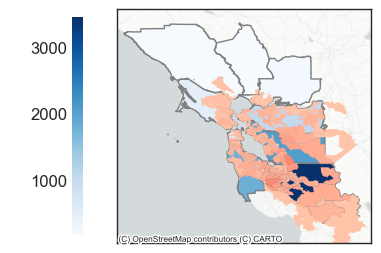

In [30]:
# fig, ax = plt.subplots(figsize=(4,4))

# evcs_sfbay_vis = pd.pivot_table(evcs_sfbay, values='Quantity', index=['ZCTA5CE10'],aggfunc=np.sum).reset_index()
# geozip_merge = geozip.merge(evcs_sfbay_vis,right_on='ZCTA5CE10',left_on='ZCTA5CE10', how='left')
# geozip_merge = gpd.sjoin(geozip_merge,geocounty)
# geozip_merge = pd.pivot_table(geozip_merge, values=['Quantity'], index=['county'], aggfunc=np.sum).reset_index()
# geozip_merge = GeoDataFrame(geozip_merge.merge(geocounty,right_on='county',left_on='county', how='left'))
# ax = geozip_merge.plot(ax = ax, column ='Quantity',cmap='Blues', legend=False, edgecolor='grey')

# comparison_rate_1 = 20; comparison_rate_2 = 100
# demand_supply = pd.read_csv('results/demand.csv')
# map_data = demand_supply[demand_supply['adoption rate']==comparison_rate_1]
# map_data['week_peak_diff'] = (map_data['week_peak_after']-map_data['week_peak_before'])/1000
# map_data['week_offpeak_diff'] = (map_data['week_offpeak_after']-map_data['week_offpeak_before'])/1000
# map_data['zipcode'] = map_data['zipcode'].astype(str)
# geozip_merge = geozip.merge(map_data,right_on='zipcode',left_on='ZCTA5CE10',how='left')
# ax= geozip_merge.plot(ax = ax, column='week_peak_diff', cmap=redcmap, legend=False, edgecolor="face", linewidth=0.1, vmin =-30)

# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_xlim(-123.6, -121.1)
# ax.set_ylim(36.7, 39.0)
# cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs=geocs.crs, attribution_size=6)
# cb = plt.colorbar(ax.collections[0], ax=ax, shrink=0.6, label = space_symbol, location = 'left')
# cb.outline.set_visible(False)
# plt.tight_layout()
# plt.show()

# 2. Session Shift Recommendation

## 2.1 Run the Results

In [16]:
peak_start = 17; peak_end=21
week_peak = []; week_offpeak = []; weekend = []
for hour in range(168*6):
    if hour<5*24*6:
        if ((hour/6)%24 >= peak_start) and ((hour/6)%24 < peak_end):
            week_peak.append(hour)
        else:
            week_offpeak.append(hour)
    else:
        week_offpeak.append(hour)

In [9]:
userTraj_label = pickle.load(open('results/userTraj_label_week.pkl', 'rb'), encoding='bytes')
userTraj_time = pickle.load(open('results/userTraj_time_week.pkl', 'rb'), encoding='bytes')
userTraj_zipcode = pickle.load(open('results/userTraj_zipcode_week.pkl', 'rb'), encoding='bytes')

userTraj_soc_timegeo = pickle.load(open('results/userTraj_soc_timegeo_'+str(mode)+'.pkl', 'rb'), encoding='bytes')
userTraj_capacity_timegeo = pickle.load(open('results/userTraj_capacity_timegeo_'+str(mode)+'.pkl', 'rb'), encoding='bytes')
userTraj_session_timegeo = pickle.load(open('results/userTraj_session_timegeo_'+str(mode)+'.pkl', 'rb'), encoding='bytes')
userTraj_energy_timegeo = pickle.load(open('results/userTraj_energy_timegeo_'+str(mode)+'.pkl', 'rb'), encoding='bytes')

df_user_inf = pickle.load(open('results/df_user_inf_update_'+str(mode)+'.pkl', 'rb'), encoding='bytes')
df_user_session = pd.read_csv('results/simulated_session_update_'+str(mode)+'.csv')
# user_select = pickle.load(open('results/selected_EV_Drivers_' + str(year) + 'p.pkl', 'rb'), encoding='bytes')
user_select = list(df_user_session['id'].unique())
user_num = len(user_select)

In [10]:
def parallelize_dataframe(args, func, n_cores):
    pool = Pool(n_cores)
    results = pool.map(func,args)
    pool.close()
    pool.join()
    return results

def calDemand(batch_id):
    run_core = 48
    user_select_batch = user_select[batch_id*np.ceil(user_num/run_core).astype(int):(batch_id+1)*np.ceil(user_num/run_core).astype(int)]
    df_total = df_user_session[df_user_session['userID'].isin(user_select_batch)].copy()
    capacity_upper = 1; capacity_lower = 0.2
    session_rate = {'home_l1':1.2, 'home_l2':6.6, 'mud_l2':6.6, 'work_l2':6.6, 'public_l2':6.6, 'public_l3':50}
    list_of_df = []

    for id in user_select_batch:
        df = df_total[(df_total['id']==id)].copy()
        arrive_time = df['arrive_time'].values.copy()
        departure_time = df['depature_time'].values.copy()
        session_type = df['session_type'].values.copy()
        session = df['session_energy'].values.copy()
        
        out_id = df['id'].values.copy()
        out_arrive_time = df['arrive_time'].values.copy()
        out_departure_time= df['depature_time'].values.copy()
        out_session_energy = df['session_energy'].values.copy()
        out_session_type = df['session_type'].values.copy()
        out_stay_type = df['stay_type'].values.copy()
        out_stay_zipcode = df['stay_zipcode'].values.copy()
        out_is_peak=np.zeros(len(arrive_time))
        out_is_shift=np.zeros(len(arrive_time))

        label = np.array(userTraj_label[id]).copy()
        stay_zipcode = np.array(userTraj_zipcode[id]).copy()
        userTraj_soc = userTraj_soc_timegeo[id]
        capacity = userTraj_capacity_timegeo[id]
        n_places = len(label)

        for i in range(n_places):
            b_session_start = int(arrive_time[i])
            b_session_end = int(arrive_time[i]+out_session_energy[i]/session_rate[out_session_type[i]]*6+1)
            b_session_energy = out_session_energy[i]

            if (out_session_energy[i]>0) and (set(range(b_session_start,b_session_end)) & set(week_peak)):
                out_is_peak[i] = 1
                for k in [1,-1,2,-2,3,-3,4,-4,5,-5,6,-6,7,-7,-8,8,9,-9]: 
                    j = i+k
                    if j<n_places and j>=0:
                        a_session_start = int(arrive_time[j])
                        a_session_end = int(arrive_time[j]+(session[j]+b_session_energy)/session_rate[session_type[j]]*6+1) 
                        a_session_departure = departure_time[j]
                        a_soc = userTraj_soc.copy() #userTraj_soc_start[id]+np.cumsum(session)[:max(i,j)+1]-userTraj_discharging[id][:max(i,j)+1]
                        a_soc[2*i:] = a_soc[2*i:]-b_session_energy
                        a_soc[2*j:] = a_soc[2*j:]+b_session_energy

                        if ((set(range(a_session_start,a_session_end)) & set(week_peak))==set()) and \
                        (a_session_end<=a_session_departure) and \
                        (min(a_soc)>=capacity_lower*capacity) and (max(a_soc)<=capacity*capacity_upper):
                            session[j] = session[j]+b_session_energy; session[i] = session[i]-b_session_energy
                            userTraj_soc[2*j:] = userTraj_soc[2*j:]+b_session_energy
                            userTraj_soc[2*i:] = userTraj_soc[2*i:]-b_session_energy

                            out_arrive_time[i] = arrive_time[j]
                            out_departure_time[i] = departure_time[j]
                            out_session_type[i] = session_type[j]
                            try:
                                out_stay_zipcode[i] = stay_zipcode[j]
                            except:
                                out_stay_zipcode[i] = np.nan

                            out_is_shift[i] = k
                            break
                    
        df_id = pd.DataFrame({'id':out_id, 'arrive_time':out_arrive_time, \
            'depature_time':out_departure_time, 'session_energy': out_session_energy,\
             'stay_zipcode':out_stay_zipcode, 'session_type':out_session_type, 'original_session_type':session_type, \
             'original_arrive_time':arrive_time, 'original_depature_time':departure_time, \
             'is_peak': out_is_peak, 'is_shift': out_is_shift})
        list_of_df.append(df_id)
    df_concat = pd.concat(list_of_df)
    pickle.dump(df_concat, open('results/userTraj_session_shift'+str(batch_id)+'.pkl','wb'), pickle.HIGHEST_PROTOCOL)

In [11]:
results = parallelize_dataframe([bathch_id for bathch_id in range(24)],calDemand, n_cores=24)
results = parallelize_dataframe([bathch_id for bathch_id in range(24,48)],calDemand, n_cores=24)
df_chunks = [] 
for batch_id in range(48):
    df_chunks.append(pickle.load(open('results/userTraj_session_shift'+str(batch_id)+'.pkl', 'rb'), encoding='bytes'))
df_shift_session = pd.concat(df_chunks)
df_shift_session.to_csv('results/simulated_session_shift_'+str(mode)+'.csv',index=False)

## 2.2 Validate the Results

In [12]:
df_user_session = pd.read_csv('results/simulated_session_update_'+str(mode)+'.csv')
df_shift_session = pd.read_csv('results/simulated_session_shift_'+str(mode)+'.csv')
user_select = pickle.load(open('results/selected_EV_Drivers_' + str(year) + 'p.pkl', 'rb'), encoding='bytes')
df_before = df_user_session[df_user_session['id'].isin(user_select)]
df_after = df_shift_session[df_shift_session['id'].isin(user_select)]
df_before = pd.pivot_table(df_before,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()
df_after = pd.pivot_table(df_after,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()
zipcode_list = df_before['stay_zipcode'].unique()

In [4]:
def simEVLoad(df):
    home_l2_rate = 6.6
    work_l2_rate = 6.6
    mud_l2_rate = 6.6
    public_l2_rate = 6.6
    home_l1_rate = 1.2
    public_l3_rate = 50
    dayhour = 24*7

    df_home_l1 = df[(df['session_type']=='home_l1')]
    df_home_l1['charge_end_time'] = np.minimum(df_home_l1['arrive_time']+(df_home_l1['session_energy']/home_l1_rate)*6,df_home_l1['depature_time'])

    df_home_l2 = df[(df['session_type']=='home_l2')]
    df_home_l2['charge_end_time'] = np.minimum(df_home_l2['arrive_time']+(df_home_l2['session_energy']/home_l2_rate)*6,df_home_l2['depature_time'])
    
    df_home_l3 = df[(df['session_type']=='mud_l2')]
    df_home_l3['charge_end_time'] = np.minimum(df_home_l3['arrive_time']+(df_home_l3['session_energy']/mud_l2_rate)*6,df_home_l3['depature_time'])
    
    df_work = df[df['session_type']=='work_l2']
    df_work['charge_end_time'] = np.minimum(df_work['arrive_time']+(df_work['session_energy']/work_l2_rate)*6,df_work['depature_time'])
    
    df_other_l2 = df[df['session_type']=='public_l2']
    df_other_l2['charge_end_time'] = np.minimum(df_other_l2['arrive_time']+(df_other_l2['session_energy']/public_l2_rate)*6,df_other_l2['depature_time'])
    df_other_l3 = df[df['session_type']=='public_l3']
    df_other_l3['charge_end_time'] = np.minimum(df_other_l3['arrive_time']+(df_other_l3['session_energy']/public_l3_rate)*6,df_other_l3['depature_time'])

    home_demand_l1 = {}; home_demand_l2 = {}; home_demand_l3 = {}; other_demand_l2 = {}; other_demand_l3 = {}; 
    total_demand = {}; home_demand = {}; other_demand = {}; work_demand = {}

    for zipcode in zipcode_list:
        df_home_1 = df_home_l1[(df_home_l1['session_energy']!=0)&(df_home_l1['stay_zipcode']==zipcode)]
        start_time_1 = (df_home_1['arrive_time']/6).astype(int).values
        end_time_1 = (df_home_1['charge_end_time']/6).astype(int).values
        home_matrix = np.zeros((len(df_home_1),dayhour))
        for i in range(len(start_time_1)):
            home_matrix[i,start_time_1[i]:end_time_1[i]+1] = home_l1_rate
        home_demand_l1[zipcode] = np.sum(home_matrix,axis=0)

        df_home_1 = df_home_l2[(df_home_l2['session_energy']!=0)&(df_home_l2['stay_zipcode']==zipcode)]
        start_time_1 = (df_home_1['arrive_time']/6).astype(int).values
        end_time_1 = (df_home_1['charge_end_time']/6).astype(int).values
        home_matrix = np.zeros((len(df_home_1),dayhour))
        for i in range(len(start_time_1)):
            home_matrix[i,start_time_1[i]:end_time_1[i]+1] = home_l2_rate
        home_demand_l2[zipcode] = np.sum(home_matrix,axis=0)

        df_home_1 = df_home_l3[(df_home_l3['session_energy']!=0)&(df_home_l3['stay_zipcode']==zipcode)]
        start_time_1 = (df_home_1['arrive_time']/6).astype(int).values
        end_time_1 = (df_home_1['charge_end_time']/6).astype(int).values
        home_matrix = np.zeros((len(df_home_1),dayhour))
        for i in range(len(start_time_1)):
            home_matrix[i,start_time_1[i]:end_time_1[i]+1] = mud_l2_rate
        home_demand_l3[zipcode] = np.sum(home_matrix,axis=0)

        df_work_1 = df_work[(df_work['session_energy']!=0)&(df_work['stay_zipcode']==zipcode)]
        start_time =(df_work_1['arrive_time']/6).astype(int).values
        end_time = (df_work_1['charge_end_time']/6).astype(int).values
        work_matrix = np.zeros((len(df_work_1),dayhour))
        for i in range(len(start_time)):
            work_matrix[i,start_time[i]:end_time[i]+1] = work_l2_rate
        work_demand[zipcode] = np.sum(work_matrix,axis=0)

        df_other_1 = df_other_l2[(df_other_l2['session_energy']!=0)&(df_other_l2['stay_zipcode']==zipcode)]
        start_time =(df_other_1['arrive_time']/6).astype(int).values
        end_time = (df_other_1['charge_end_time']/6).astype(int).values
        other_matrix = np.zeros((len(df_other_1),dayhour))
        for i in range(len(start_time)):
            other_matrix[i,start_time[i]:end_time[i]+1] = public_l2_rate
        other_demand_l2[zipcode] = np.sum(other_matrix,axis=0)

        df_other_1 = df_other_l3[(df_other_l3['session_energy']!=0)&(df_other_l3['stay_zipcode']==zipcode)]
        start_time =(df_other_1['arrive_time']/6).astype(int).values
        end_time = (df_other_1['charge_end_time']/6).astype(int).values
        other_matrix = np.zeros((len(df_other_1),dayhour))
        for i in range(len(start_time)):
            other_matrix[i,start_time[i]:end_time[i]+1] = public_l3_rate
        other_demand_l3[zipcode] = np.sum(other_matrix,axis=0)

        home_demand[zipcode] = home_demand_l1[zipcode]+home_demand_l2[zipcode]+home_demand_l3[zipcode]
        other_demand[zipcode] = other_demand_l3[zipcode]+other_demand_l2[zipcode]
        total_demand[zipcode] = work_demand[zipcode]+other_demand[zipcode]+home_demand[zipcode]
    
    home = pd.DataFrame.from_dict(home_demand, orient='index')
    work = pd.DataFrame.from_dict(work_demand, orient='index')
    other = pd.DataFrame.from_dict(other_demand, orient='index')
    total = pd.DataFrame.from_dict(total_demand, orient='index')
    return home, work, other, total

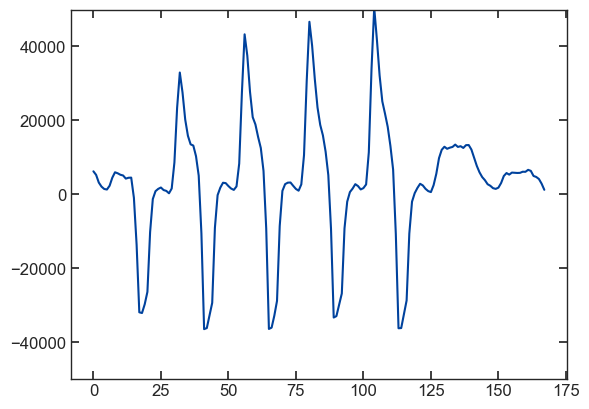

5188351.4 5738101.4


In [14]:
home_load, work_load, other_load, total_load = simEVLoad(df_before)
homes_load, works_load, others_load, totals_load = simEVLoad(df_after)
plt.plot((totals_load.sum(axis=0)-total_load.sum(axis=0)))
plt.ylim([-50000,50000])
plt.show()
print(np.sum(np.sum(total_load)),np.sum(np.sum(totals_load)))

## 2.3 Get results for future adoption rates

In [18]:
peak_start = 17; peak_end=21
week_peak = []; week_offpeak = []; weekend = []
for hour in range(168):
    if hour<5*24:
        if ((hour)%24 >= peak_start) and ((hour)%24 < peak_end):
            week_peak.append(hour)
        else:
            week_offpeak.append(hour)
    else:
        week_offpeak.append(hour)

In [19]:
#for (year,rate) in zip([0],[2]):
for (year,rate) in zip([0,1,2,3,4,5,6,0.3,0.5],[2,3,20,40,60,80,100,0.3,0.5]):
    if year == 0:
        user_select = pickle.load(open('results/selected_EV_Drivers_' + str(year) + 'p.pkl', 'rb'), encoding='bytes')
        df_before = df_user_session[df_user_session['id'].isin(user_select)]
        df_after = df_shift_session[df_shift_session['id'].isin(user_select)]
        df_before = df_before.fillna(-1)
        df_after = df_after.fillna(-1)
        df_before = pd.pivot_table(df_before,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()
        df_after = pd.pivot_table(df_after,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()
        zipcode_list = df_before['stay_zipcode'].unique()

        home_load, work_load, other_load, total_load = simEVLoad(df_before)
        homes_load, works_load, others_load, totals_load = simEVLoad(df_after)

        total = total_load
        totals = totals_load

        week_peak_total = total.values[:,week_peak]
        week_offpeak_total = total.values[:,week_offpeak]

        week_peak_totals = totals.values[:,week_peak]
        week_offpeak_totals = totals.values[:,week_offpeak]

        demand_results = pd.DataFrame({'zipcode':total.index,'week_peak_before':np.max(week_peak_total,axis=1),'week_offpeak_before':np.max(week_offpeak_total,axis=1),\
                'week_peak_after':np.max(week_peak_totals,axis=1),'week_offpeak_after':np.max(week_offpeak_totals,axis=1)})
        demand_results = demand_results.loc[demand_results.zipcode.notna()]
        demand_results['zipcode'] = demand_results['zipcode'].astype(int).astype(str)
        demand_supply_results = demand_results.merge(evcs_sfbay_power, left_on ='zipcode', right_on='ZCTA5CE10')

        demand_supply_results['adoption rate'] = rate
        demand_supply = demand_supply_results
    
    else:
        user_select = pickle.load(open('results/selected_EV_Drivers_' + str(year) + 'p.pkl', 'rb'), encoding='bytes')
        df_before = df_user_session[df_user_session['id'].isin(user_select)]
        df_after = df_shift_session[df_shift_session['id'].isin(user_select)]
        df_before = df_before.fillna(-1)
        df_after = df_after.fillna(-1)
        df_before = pd.pivot_table(df_before,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()
        df_after = pd.pivot_table(df_after,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()

        home_load, work_load, other_load, total_load = simEVLoad(df_before)
        homes_load, works_load, others_load, totals_load = simEVLoad(df_after)

        total = total_load
        totals = totals_load

        week_peak_total = total.values[:,week_peak]
        week_offpeak_total = total.values[:,week_offpeak]

        week_peak_totals = totals.values[:,week_peak]
        week_offpeak_totals = totals.values[:,week_offpeak]

        demand_results = pd.DataFrame({'zipcode':total.index,'week_peak_before':np.max(week_peak_total,axis=1),'week_offpeak_before':np.max(week_offpeak_total,axis=1),\
                'week_peak_after':np.max(week_peak_totals,axis=1),'week_offpeak_after':np.max(week_offpeak_totals,axis=1)})
        demand_results = demand_results.loc[demand_results.zipcode.notna()]
        demand_results['zipcode'] = demand_results['zipcode'].astype(int).astype(str)
        demand_supply_results = demand_results.merge(evcs_sfbay_power, left_on ='zipcode', right_on='ZCTA5CE10')
        demand_supply_results['adoption rate'] = rate
        demand_supply = pd.concat([demand_supply, demand_supply_results])

demand_supply.to_csv('results/demand.csv',index=False)

In [20]:
#for (year,rate) in zip([0],[2]):
for (year,rate) in zip([0,1,2,3,4,5,6,0.3,0.5],[2,3,20,40,60,80,100,0.3,0.5]):
    if year == 0:
        user_select = pickle.load(open('results/selected_EV_Drivers_' + str(year) + 'p.pkl', 'rb'), encoding='bytes')
        df_before = df_user_session[df_user_session['id'].isin(user_select)]
        df_after = df_shift_session[df_shift_session['id'].isin(user_select)]
        df_before = df_before.fillna(-1)
        df_after = df_after.fillna(-1)
        df_before = pd.pivot_table(df_before,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()
        df_after = pd.pivot_table(df_after,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()
        zipcode_list = df_before['stay_zipcode'].unique()
        
        home_load, work_load, other_load, total_load = simEVLoad(df_before)
        homes_load, works_load, others_load, totals_load = simEVLoad(df_after)

        total = other_load
        totals = others_load

        week_peak_total = total.values[:,week_peak]
        week_offpeak_total = total.values[:,week_offpeak]

        week_peak_totals = totals.values[:,week_peak]
        week_offpeak_totals = totals.values[:,week_offpeak]

        demand_results = pd.DataFrame({'zipcode':total.index,'week_peak_before':np.max(week_peak_total,axis=1),'week_offpeak_before':np.max(week_offpeak_total,axis=1),\
                'week_peak_after':np.max(week_peak_totals,axis=1),'week_offpeak_after':np.max(week_offpeak_totals,axis=1)})
        demand_results = demand_results.loc[demand_results.zipcode.notna()]
        demand_results['zipcode'] = demand_results['zipcode'].astype(int).astype(str)
        demand_supply_results = demand_results.merge(evcs_sfbay_power, left_on ='zipcode', right_on='ZCTA5CE10')

        demand_supply_results['week_peak_before_gap'] = demand_supply_results['Power']-demand_supply_results['week_peak_before']
        demand_supply_results['week_offpeak_before_gap'] = demand_supply_results['Power']-demand_supply_results['week_offpeak_before']

        demand_supply_results['week_peak_after_gap'] = demand_supply_results['Power']-demand_supply_results['week_peak_after']
        demand_supply_results['week_offpeak_after_gap'] = demand_supply_results['Power']-demand_supply_results['week_offpeak_after']
        demand_supply_results['adoption rate'] = rate
        demand_supply = demand_supply_results
    else:
        user_select = pickle.load(open('results/selected_EV_Drivers_' + str(year) + 'p.pkl', 'rb'), encoding='bytes')
        df_before = df_user_session[df_user_session['id'].isin(user_select)]
        df_after = df_shift_session[df_shift_session['id'].isin(user_select)]
        df_before = df_before.fillna(-1)
        df_after = df_after.fillna(-1)
        df_before = pd.pivot_table(df_before,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()
        df_after = pd.pivot_table(df_after,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()

        home_load, work_load, other_load, total_load = simEVLoad(df_before)
        homes_load, works_load, others_load, totals_load = simEVLoad(df_after)

        total = other_load
        totals = others_load

        week_peak_total = total.values[:,week_peak]
        week_offpeak_total = total.values[:,week_offpeak]

        week_peak_totals = totals.values[:,week_peak]
        week_offpeak_totals = totals.values[:,week_offpeak]

        demand_results = pd.DataFrame({'zipcode':total.index,'week_peak_before':np.max(week_peak_total,axis=1),'week_offpeak_before':np.max(week_offpeak_total,axis=1),\
                'week_peak_after':np.max(week_peak_totals,axis=1),'week_offpeak_after':np.max(week_offpeak_totals,axis=1)})
        demand_results = demand_results.loc[demand_results.zipcode.notna()]
        demand_results['zipcode'] = demand_results['zipcode'].astype(int).astype(str)
        demand_supply_results = demand_results.merge(evcs_sfbay_power, left_on ='zipcode', right_on='ZCTA5CE10')

        demand_supply_results['week_peak_before_gap'] = demand_supply_results['Power']-demand_supply_results['week_peak_before']
        demand_supply_results['week_offpeak_before_gap'] = demand_supply_results['Power']-demand_supply_results['week_offpeak_before']

        demand_supply_results['week_peak_after_gap'] = demand_supply_results['Power']-demand_supply_results['week_peak_after']
        demand_supply_results['week_offpeak_after_gap'] = demand_supply_results['Power']-demand_supply_results['week_offpeak_after']
        demand_supply_results['adoption rate'] = rate
        demand_supply = pd.concat([demand_supply, demand_supply_results])

demand_supply.to_csv('results/supply.csv',index=False)

# 3. Analysis with Current Adoption Rate

## 3.1 Whole Bay Area

In [69]:
df_user_session = pd.read_csv('results/simulated_session_update_'+str(mode)+'.csv')
df_shift_session = pd.read_csv('results/simulated_session_shift_'+str(mode)+'.csv')
user_select = pickle.load(open('results/selected_EV_Drivers_' + str(year) + 'p.pkl', 'rb'), encoding='bytes')
df_before = df_user_session[df_user_session['id'].isin(user_select)]; df_after = df_shift_session[df_shift_session['id'].isin(user_select)]
df_before = df_before.fillna(-1); df_after = df_after.fillna(-1)
df_before = pd.pivot_table(df_before,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()
df_after = pd.pivot_table(df_after,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()
zipcode_list = df_before['stay_zipcode'].unique()
home_load, work_load, other_load, total_load = simEVLoad(df_before)
homes_load, works_load, others_load, totals_load = simEVLoad(df_after)

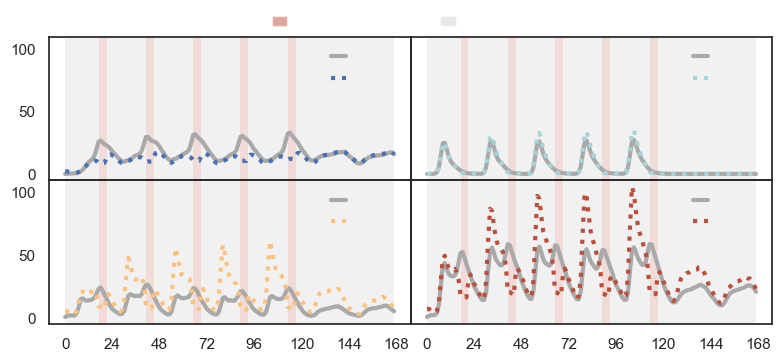

In [74]:
peak_start = 17; peak_end=21
week_peak = np.zeros(168); week_offpeak = np.zeros(168)
for hour in range(168):
    if hour<24*5:
        if (hour%24 > peak_start) and (hour%24 < peak_end):
            week_peak[hour] = 1
        elif (hour%24 == peak_start) or (hour%24 == peak_end):
            week_peak[hour] = 1
            week_offpeak[hour] = 1
        else:
            week_offpeak[hour] = 1
    else:
        week_offpeak[hour] = 1        

fig, ax = plt.subplots(nrows=2, ncols=2, sharey = True, figsize=(8,3.5))
legend_elements = [Patch(facecolor=color_platte[7], alpha=0.5,
                         label='                          '),
                   Patch(facecolor='lightgrey', alpha=0.5,
                         label='                          ')]
fig.legend(handles=legend_elements,frameon=False,ncol=2,bbox_to_anchor=(0.75, 1.05))
ax[0,0].plot(np.sum(home_load/1000,axis=0),c ='darkgrey',label='         ',linewidth=3)
ax[0,0].plot(np.sum(homes_load/1000,axis=0),c =color_platte[1],label='         ',linestyle = 'dotted',linewidth=3)
ax[0,0].fill_between(range(168), 0, 1, where=week_peak, alpha=0.2,  linewidth =0, color=color_platte[7], transform=ax[0,0].get_xaxis_transform())
ax[0,0].fill_between(range(168), 0, 1, where=week_offpeak, alpha=0.3, linewidth =0,  color='lightgrey', transform=ax[0,0].get_xaxis_transform())
ax[0,0].set_xticks([])
ax[0,0].legend(frameon=False)

ax[0,1].plot(np.sum(work_load/1000,axis=0),c ='darkgrey',label='         ',linewidth=3)
ax[0,1].plot(np.sum(works_load/1000,axis=0),c =color_platte[3],label='         ',linestyle = 'dotted',linewidth=3)
ax[0,1].fill_between(range(168), 0, 1, where=week_peak, alpha=0.2,  linewidth =0, color=color_platte[7], transform=ax[0,1].get_xaxis_transform())
ax[0,1].fill_between(range(168), 0, 1, where=week_offpeak, alpha=0.3, linewidth =0,  color='lightgrey', transform=ax[0,1].get_xaxis_transform())
ax[0,1].set_xticks([])
ax[0,1].legend(frameon=False)

ax[1,0].plot(np.sum(other_load/1000,axis=0),c = 'darkgrey', label='         ',linewidth=3)
ax[1,0].plot(np.sum(others_load/1000,axis=0),c =color_platte[5],label='         ',linestyle = 'dotted',linewidth=3)
ax[1,0].fill_between(range(168), 0, 1, where=week_peak, alpha=0.2,  linewidth =0, color=color_platte[7], transform=ax[1,0].get_xaxis_transform())
ax[1,0].fill_between(range(168), 0, 1, where=week_offpeak, alpha=0.3, linewidth =0,  color='lightgrey', transform=ax[1,0].get_xaxis_transform())
ax[1,0].set_xticks([0,24,48,72,96,120,144,168])
ax[1,0].legend(frameon=False)

ax[1,1].plot(np.sum(total_load/1000,axis=0),c = 'darkgrey',label='         ',linewidth=3)
ax[1,1].plot(np.sum(totals_load/1000,axis=0),c =color_platte[7],label='         ',linestyle = 'dotted',linewidth=3)
ax[1,1].fill_between(range(168), 0, 1, where=week_peak, alpha=0.2,  linewidth =0, color=color_platte[7], transform=ax[1,1].get_xaxis_transform())
ax[1,1].fill_between(range(168), 0, 1, where=week_offpeak, alpha=0.3, linewidth =0,  color='lightgrey', transform=ax[1,1].get_xaxis_transform())
ax[1,1].set_xticks([0,24,48,72,96,120,144,168])
ax[1,1].legend(frameon=False)

plt.tight_layout()
plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig('figures/fig3_temporal_shifting.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

## 3.2 ZIP code Level

In [24]:
current_rate = 2

### 3.2.1 Bar Plot

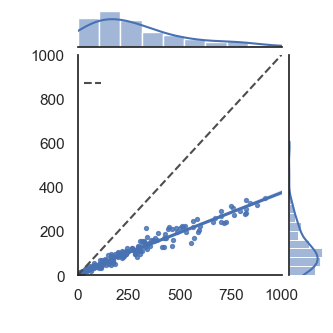

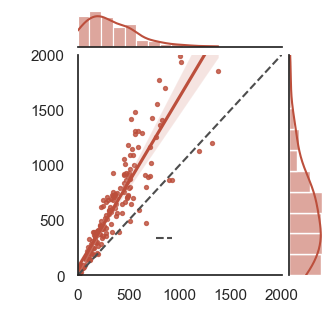

In [26]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
#color_platte = ['#00429d', '#4771b2', '#73a2c6', '#a5d5d8', '#ffffe0', '#fcc17e', '#e0884e', '#bc4f3c', '#93003a']
geozip = gpd.read_file("data/census/sfbay_zip.geojson")
demand_supply = pd.read_csv('results/demand.csv')

demand_supply_results = demand_supply[demand_supply['adoption rate']==current_rate]
g = sns.jointplot(x='week_peak_before', y='week_peak_after', data=demand_supply_results, 
                kind="reg", truncate=True,height=3.5,xlim=(0,1000),ylim=(0,1000),color=color_platte[1], scatter_kws={"s": 8})
g.ax_joint.set_xlabel('          ',fontsize=fsize)
g.ax_joint.set_ylabel('          ',fontsize=fsize)
plt.plot([0, 3000], [0, 3000], ls="--", c=".3", label='        ')
plt.legend(frameon=False, fontsize = fsize, loc = [0.0,0.8])
plt.savefig('figures/fig3_joint_peak.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

g = sns.jointplot(x='week_offpeak_before', y='week_offpeak_after', data=demand_supply_results,
                kind="reg", truncate=True,height=3.5,xlim=(0,2000),ylim=(0,2000),color=color_platte[7], scatter_kws={"s": 8})
plt.plot([0, 3000], [0, 3000], ls="--", c=".3", label='           ')
plt.legend(frameon=False, fontsize = fsize, loc = [0.35,0.1])
g.ax_joint.set_xlabel('          ',fontsize=fsize)
g.ax_joint.set_ylabel('          ',fontsize=fsize)
plt.savefig('figures/fig3_joint_offpeak.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()


### 3.2 scatter plot

In [27]:
demand_supply = pd.read_csv('results/supply.csv')
demand_supply['zipcode'] = demand_supply['zipcode'].astype(str)
demand_supply_results = demand_supply[demand_supply['adoption rate']==current_rate]
geozip_merge = geozip.merge(demand_supply_results,right_on='zipcode',left_on='ZCTA5CE10')
geocounty = gpd.read_file("data/census/Bay Area Counties.geojson")
geocounty = gpd.sjoin(geozip_merge,geocounty)
contyheat = pd.pivot_table(geocounty, values=['week_peak_before', 'week_offpeak_before', 'week_peak_after',
       'week_offpeak_after','Power'], index=['zipcode','county'], aggfunc=np.sum).reset_index()
geocounty = geocounty[['zipcode', 'week_peak_before', 'week_offpeak_before',
       'week_peak_after', 'week_offpeak_after', 'Power', 'adoption rate','county']]

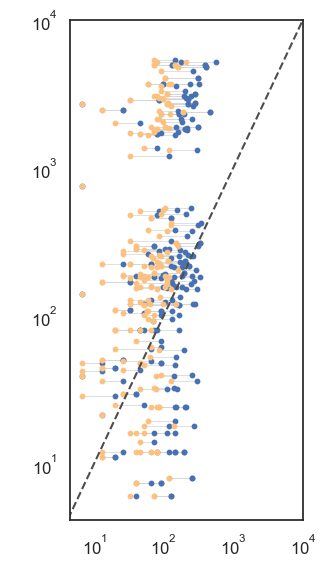

In [86]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
countyvis = pd.melt(contyheat, id_vars=['zipcode','Power','county'], value_vars=['week_peak_before', 'week_peak_after'])
X_coords = np.array([contyheat.week_peak_before.values,contyheat.week_peak_after.values])
Y_coords = np.array([contyheat.Power.values,contyheat.Power.values])
plt.figure(figsize=(3,6.5))

plt.plot(X_coords, 
         Y_coords, 
         linewidth = 0.5,
         color='lightgray',zorder=1)
colors = {'week_peak_before':color_platte[1],'week_peak_after':color_platte[7]}

countyvis_before = countyvis[countyvis['variable']=='week_peak_before']
countyvis_after = countyvis[countyvis['variable']=='week_peak_after']
plt.scatter(countyvis_before.value, 
            countyvis_before.Power,
            s=10,
            c=color_platte[1],zorder=2,label='           ')

plt.scatter(countyvis_after.value, 
            countyvis_after.Power,
            s=10,
            c=color_platte[5],zorder=2,label='           ')

plt.plot([0,10000],[0,10000],ls="--", c=".3", label='           ')
plt.yscale('log')
plt.xscale('log')
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('           ', x=0.33,y=0.95,size=fsize)
plt.xlabel("           ", size=fsize)
plt.ylabel("           ", size=fsize)
plt.savefig('figures/fig3_scatter_peak.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

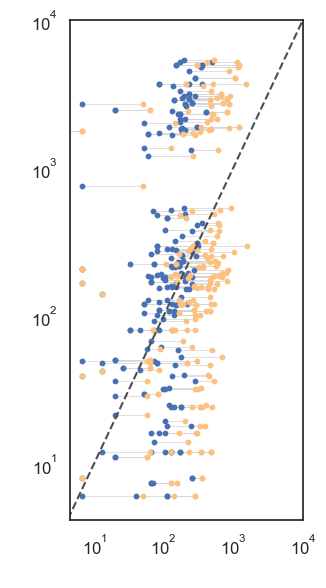

In [85]:
countyvis = pd.melt(contyheat, id_vars=['zipcode','Power'], value_vars=['week_offpeak_before', 'week_offpeak_after'])
X_coords = np.array([contyheat.week_offpeak_before.values,contyheat.week_offpeak_after.values])
Y_coords = np.array([contyheat.Power.values,contyheat.Power.values])
plt.figure(figsize=(3,6.5))
plt.plot(X_coords, 
         Y_coords, 
         linewidth = 0.5,
         color='lightgray',zorder=1)

countyvis_before = countyvis[countyvis['variable']=='week_offpeak_before']
countyvis_after = countyvis[countyvis['variable']=='week_offpeak_after']

plt.scatter(countyvis_before.value, 
            countyvis_before.Power,
            s=10,
            c=color_platte[1],zorder=2,label='              ')

plt.scatter(countyvis_after.value, 
            countyvis_after.Power,
            s=10,
            c=color_platte[5],zorder=2,label='              ')

plt.plot([0,10000],[0,10000],ls="--", c=".3", label='              ')
plt.yscale('log')
plt.xscale('log')
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('           ', fontsize=fsize,x=0.38,y=0.95)
plt.xlabel("           ", size=fsize)
plt.ylabel("           ", size=fsize)
# plt.legend(frameon=False,loc='lower right',fontsize = fsize, ncol=3, bbox_to_anchor=(1., 1.0))
plt.savefig('figures/fig3_scatter_offpeak.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

# 4. Increasing Adoption Rate

In [5]:
future_rate = 3

## 4.1 Cat plot

In [6]:
demand_supply = pd.read_csv('results/demand.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']>future_rate]

peakridge = demand_supply_results.copy()
peakridge['shifting'] = ' '
peakridge['day'] = 'Grid Peak Hours'
peakridge['peak value'] = peakridge['week_peak_before']/1000
peakridges = peakridge.copy()

peakridge['shifting'] = '   '
peakridge['day'] = 'Grid Peak Hours'
peakridge['peak value'] = peakridge['week_peak_after']/1000
peakridges = pd.concat([peakridges,peakridge.copy()])

offpeakridge = demand_supply_results.copy()
offpeakridge['shifting'] = ' '
offpeakridge['day'] = 'Grid Off-Peak Hours'
offpeakridge['peak value'] = offpeakridge['week_offpeak_before']/1000
offpeakridges = offpeakridge.copy()

offpeakridge['shifting'] = '   '
offpeakridge['day'] = 'Grid Off-Peak Hours'
offpeakridge['peak value'] = offpeakridge['week_offpeak_after']/1000
offpeakridges = pd.concat([offpeakridges,offpeakridge.copy()])

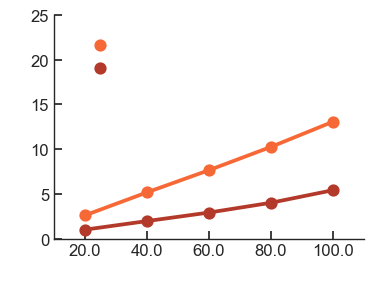

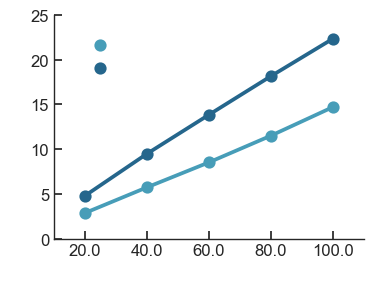

In [58]:
g = sns.catplot(
    data=peakridges, x="adoption rate", y="peak value", hue="shifting",
    capsize=.2, palette="YlOrRd_d", errorbar=None,
    kind="point", height=3, aspect=1.3, legend=False
)
g.set_xlabels('               ', fontsize=fsize)
g.set_ylabels('               ', fontsize=fsize)
g.set_titles('               ', fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.legend(frameon=False, fontsize=fsize, loc=[0.1,0.7]).set_title('')
plt.ylim([0,25])
plt.savefig('figures/fig4_cat_peak.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

g = sns.catplot(
    data=offpeakridges, x="adoption rate", y="peak value", hue="shifting", 
    capsize=.2, palette="YlGnBu_d", errorbar=None,
    kind="point", height=3, aspect=1.3, legend=False
)
g.set_xlabels('               ', fontsize=fsize)
g.set_ylabels('               ', fontsize=fsize)
g.set_titles('               ', fontsize=fsize)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=False, fontsize=fsize, loc=[0.1,0.7]).set_title('')
plt.ylim([0,25])
plt.savefig('figures/fig4_cat_offpeak.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

## 4.2 ridge plot

In [34]:
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

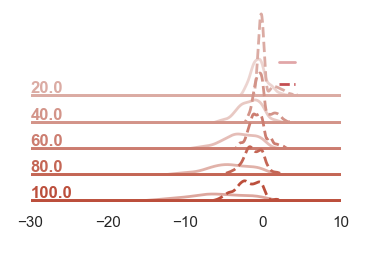

In [35]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
demand_supply = pd.read_csv('results/supply.csv')
ridges = demand_supply[demand_supply['adoption rate']>future_rate]
ridges["week_peak_before_gap"] = ridges["week_peak_before_gap"]/1000
ridges["week_peak_after_gap"] = ridges["week_peak_after_gap"]/1000
pal = sns.light_palette(color_platte[-2],len(ridges["adoption rate"].unique())+3,)
g = sns.FacetGrid(ridges, row="adoption rate", hue="adoption rate", aspect=8, height=.5, palette=pal[3:])

g.map(sns.kdeplot, "week_peak_before_gap", bw_adjust=.9, cut=5, clip_on=[-40000, 10000], alpha=0.5,  lw=2,)
g.map(sns.kdeplot, "week_peak_after_gap", bw_adjust=.6, cut=5, clip_on=[-40000, 10000],  lw=2, linestyle="dashed",)
g.map(plt.axhline, y=0, linewidth=5, linestyle="-", color=None, clip_on=[-40000, 10000])

g.map(label, "adoption rate")
g.fig.subplots_adjust(hspace=-0.7)
g.set(yticks=[], xlabel="                      ", ylabel="", title="")
g.despine(bottom=True, left=True)

legend_elements = [Line2D([0], [0], color='r', lw=2, label='            ', alpha=0.5, ),
                   Line2D([0], [0], color='r', lw=2, label='            ', linestyle='dashed')]

plt.ylabel('            ',x=-0.5,y=0.7)
plt.legend(handles=legend_elements,frameon=False,loc='lower right',bbox_to_anchor=(1.1, 1.1))
plt.xlim([-30,10])
plt.savefig('figures/fig4_ridge_peak.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

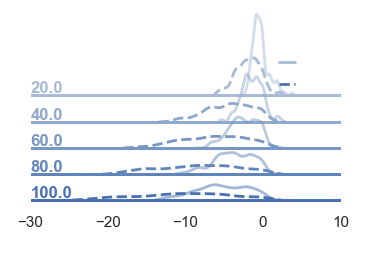

In [36]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
ridges = demand_supply[demand_supply['adoption rate']>future_rate]
ridges["week_offpeak_before_gap"] = ridges["week_offpeak_before_gap"]/1000
ridges["week_offpeak_after_gap"] = ridges["week_offpeak_after_gap"]/1000
pal = sns.light_palette(color_platte[1],len(ridges["adoption rate"].unique())+3,)
g = sns.FacetGrid(ridges, row="adoption rate", hue="adoption rate", aspect=8, height=.5, palette=pal[3:])

g.map(sns.kdeplot, "week_offpeak_before_gap", bw_adjust=.6, cut=5, clip_on=[-40000, 10000], alpha=0.5,lw=2)
g.map(sns.kdeplot, "week_offpeak_after_gap", bw_adjust=.6, cut=5, clip_on=[-40000, 10000], linewidth=2, linestyle="dashed",)
g.map(plt.axhline, y=0, linewidth=5, linestyle="-", color=None, clip_on=[-40000, 10000])

g.map(label, "adoption rate")
g.fig.subplots_adjust(hspace=-0.7)
g.set(yticks=[], xlabel="            ", ylabel="", title="")
g.despine(bottom=True, left=True)

legend_elements = [Line2D([0], [0], color='b', lw=2, label='            ', alpha=0.5, ),
                   Line2D([0], [0], color='b', lw=2, label='            ', linestyle='dashed')]

plt.ylabel('            ',x=-0.1,y=0.7)
plt.legend(handles=legend_elements,frameon=False,loc='lower right',bbox_to_anchor=(1.1, 1.1))
plt.xlim([-30,10])
plt.savefig('figures/fig4_ridge_offpeak.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

## 4.3 Distribution Map

In [37]:
comparison_rate_1 = 20; comparison_rate_2 = 100

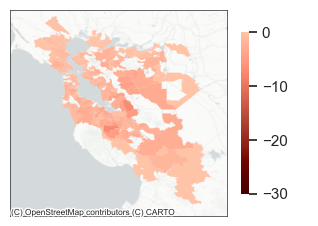

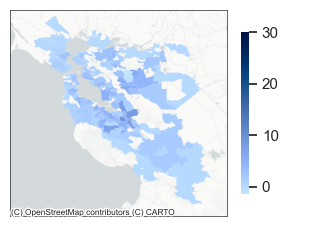

In [38]:
demand_supply = pd.read_csv('results/demand.csv')
map_data = demand_supply[demand_supply['adoption rate']==comparison_rate_1]
map_data['week_peak_diff'] = (map_data['week_peak_after']-map_data['week_peak_before'])/1000
map_data['week_offpeak_diff'] = (map_data['week_offpeak_after']-map_data['week_offpeak_before'])/1000
map_data['zipcode'] = map_data['zipcode'].astype(str)
geozip_merge = geozip.merge(map_data,right_on='zipcode',left_on='ZCTA5CE10',how='left')
fig, ax = plt.subplots(figsize=(3.5,3.5))
ax= geozip_merge.plot(ax = ax, column='week_peak_diff', cmap=redcmap, legend=False, edgecolor="face", linewidth=0.1, vmin =-30)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-123, -121)
ax.set_ylim(36.5, 38.4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
scatter = ax.collections[0]
cb = plt.colorbar(scatter, ax=ax, shrink=0.6, label = '  ')
cb.outline.set_visible(False)
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs=geozip_merge.crs,attribution_size=6)
plt.savefig('figures/fig4_geo_adp20_peak.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

map_data['zipcode'] = map_data['zipcode'].astype(str)
geozip_merge = geozip.merge(map_data,right_on='zipcode',left_on='ZCTA5CE10',how='left')
fig, ax = plt.subplots(figsize=(3.5,3.5))
ax= geozip_merge.plot(ax = ax, column='week_offpeak_diff', cmap=homecmap, legend=False, edgecolor="face", linewidth=0.1 ,vmax = 30)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-123, -121)
ax.set_ylim(36.5, 38.4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
scatter = ax.collections[0]
cb = plt.colorbar(scatter, ax=ax, shrink=0.6, label = '  ')
cb.outline.set_visible(False)
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs=geozip_merge.crs,attribution_size=6)
plt.savefig('figures/fig4_geo_adp20_offpeak.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

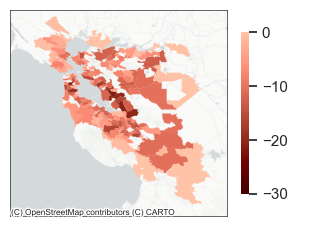

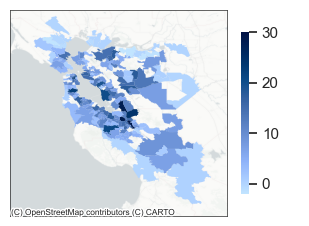

In [39]:
map_data = demand_supply[demand_supply['adoption rate']==comparison_rate_2]
map_data['week_peak_diff'] = (map_data['week_peak_after']-map_data['week_peak_before'])/1000
map_data['week_offpeak_diff'] = (map_data['week_offpeak_after']-map_data['week_offpeak_before'])/1000

map_data['zipcode'] = map_data['zipcode'].astype(str)
geozip_merge = geozip.merge(map_data,right_on='zipcode',left_on='ZCTA5CE10',how='left')
fig, ax = plt.subplots(figsize=(3.5,3.5))
ax= geozip_merge.plot(ax = ax, column='week_peak_diff', cmap=redcmap, legend=False, edgecolor="face", linewidth=0.1,vmin=-30)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-123, -121)
ax.set_ylim(36.5, 38.4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
scatter = ax.collections[0]
cb = plt.colorbar(scatter, ax=ax, shrink=0.6, label = '  ')
cb.outline.set_visible(False)
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs=geozip_merge.crs,attribution_size=6)
plt.savefig('figures/fig4_geo_adp100_peak.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

map_data['zipcode'] = map_data['zipcode'].astype(str)
geozip_merge = geozip.merge(map_data,right_on='zipcode',left_on='ZCTA5CE10',how='left')
fig, ax = plt.subplots(figsize=(3.5,3.5))
ax= geozip_merge.plot(ax = ax, column='week_offpeak_diff', cmap=homecmap, legend=False, edgecolor="face", linewidth=0.1,vmax =30)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-123, -121)
ax.set_ylim(36.5, 38.4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
scatter = ax.collections[0]
cb = plt.colorbar(scatter, ax=ax, shrink=0.6, label = '  ')
cb.outline.set_visible(False)
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs=geozip_merge.crs,attribution_size=6)
plt.savefig('figures/fig4_geo_adp100_offpeak.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

## 4.4 How the Supply and Demand Increase? 

In [111]:
demand_supply = pd.read_csv('results/demand.csv')
demand_supply = demand_supply[demand_supply['adoption rate']>3]
peak_before = pd.pivot_table(demand_supply, values='week_peak_before', index=['zipcode'],columns=['adoption rate'] ,aggfunc=np.sum)/1000
offpeak_before = pd.pivot_table(demand_supply, values='week_offpeak_before', index=['zipcode'],columns=['adoption rate'] ,aggfunc=np.sum)/1000
peak_after = pd.pivot_table(demand_supply, values='week_peak_after', index=['zipcode'],columns=['adoption rate'] ,aggfunc=np.sum)/1000
offpeak_after = pd.pivot_table(demand_supply, values='week_offpeak_after', index=['zipcode'],columns=['adoption rate'] ,aggfunc=np.sum)/1000

up_thres = 0
down_thres = 0

peak_before['40-20'] = peak_before[40]-peak_before[20]; peak_before['60-40'] = peak_before[60]-peak_before[40]; 
peak_before['80-60'] = peak_before[80]-peak_before[60]; peak_before['100-80'] = peak_before[100]-peak_before[80]
peak_before['1'] = peak_before['60-40']-peak_before['40-20']; peak_before['2'] = peak_before['80-60']-peak_before['60-40']; peak_before['3'] = peak_before['100-80']-peak_before['80-60']
peak_before['linear'] = 0
peak_before.loc[(peak_before['1']<0)&(peak_before['2']<0)&(peak_before['3']<down_thres),'linear'] = -1
peak_before.loc[(peak_before['1']>0)&(peak_before['2']>0)&(peak_before['3']>up_thres),'linear'] = 1
# peak_before.loc[(peak_before['1']+peak_before['2']+peak_before['3']<0),'linear'] = -1
# peak_before.loc[(peak_before['1']+peak_before['2']+peak_before['3']>0),'linear'] = 1

offpeak_before['40-20'] = offpeak_before[40]-offpeak_before[20]; offpeak_before['60-40'] = offpeak_before[60]-offpeak_before[40]; 
offpeak_before['80-60'] = offpeak_before[80]-offpeak_before[60]; offpeak_before['100-80'] = offpeak_before[100]-offpeak_before[80]
offpeak_before['1'] = offpeak_before['60-40']-offpeak_before['40-20']; offpeak_before['2'] = offpeak_before['80-60']-offpeak_before['60-40']; offpeak_before['3'] = offpeak_before['100-80']-offpeak_before['80-60']
offpeak_before['linear'] = 0
offpeak_before.loc[(offpeak_before['1']<0)&(offpeak_before['2']<0)&(offpeak_before['3']<down_thres),'linear'] = -1
offpeak_before.loc[(offpeak_before['1']>0)&(offpeak_before['2']>0)&(offpeak_before['3']>up_thres),'linear'] = 1
# offpeak_before.loc[(offpeak_before['1']+offpeak_before['2']+offpeak_before['3']<0),'linear'] = -1
# offpeak_before.loc[(offpeak_before['1']+offpeak_before['2']+offpeak_before['3']>0),'linear'] = 1

peak_after['40-20'] = peak_after[40]-peak_after[20]; peak_after['60-40'] = peak_after[60]-peak_after[40]; 
peak_after['80-60'] = peak_after[80]-peak_after[60]; peak_after['100-80'] = peak_after[100]-peak_after[80]
peak_after['1'] = peak_after['60-40']-peak_after['40-20']; peak_after['2'] = peak_after['80-60']-peak_after['60-40']; peak_after['3'] = peak_after['100-80']-peak_after['80-60']
peak_after['linear'] = 0
peak_after.loc[(peak_after['1']<0)&(peak_after['2']<0)&(peak_after['3']<down_thres),'linear'] = -1
peak_after.loc[(peak_after['1']>0)&(peak_after['2']>0)&(peak_after['3']>up_thres),'linear'] = 1
# peak_after.loc[(peak_after['1']+peak_after['2']+peak_after['3']<0),'linear'] = -1
# peak_after.loc[(peak_after['1']+peak_after['2']+peak_after['3']>0),'linear'] = 1

offpeak_after['40-20'] = offpeak_after[40]-offpeak_after[20]; offpeak_after['60-40'] = offpeak_after[60]-offpeak_after[40]; 
offpeak_after['80-60'] = offpeak_after[80]-offpeak_after[60]; offpeak_after['100-80'] = offpeak_after[100]-offpeak_after[80]
offpeak_after['1'] = offpeak_after['60-40']-offpeak_after['40-20']; offpeak_after['2'] = offpeak_after['80-60']-offpeak_after['60-40']; offpeak_after['3'] = offpeak_after['100-80']-offpeak_after['80-60']
offpeak_after['linear'] = 0
offpeak_after.loc[(offpeak_after['1']<0)&(offpeak_after['2']<0)&(offpeak_after['3']<down_thres),'linear'] = -1
offpeak_after.loc[(offpeak_after['1']>0)&(offpeak_after['2']>0)&(offpeak_after['3']>up_thres),'linear'] = 1
# offpeak_after.loc[(offpeak_after['1']+offpeak_after['2']+offpeak_after['3']<0),'linear'] = -1
# offpeak_after.loc[(offpeak_after['1']+offpeak_after['2']+offpeak_after['3']>0),'linear'] = 1

linear_map = pd.DataFrame()
linear_map['peak_before'] = peak_before['linear']
linear_map['peak_after'] = peak_after['linear']
linear_map['offpeak_before'] = offpeak_before['linear']
linear_map['offpeak_after'] = offpeak_after['linear']
linear_map = linear_map.reset_index()

In [125]:
pd.pivot_table(linear_map, values='zipcode', columns=['peak_before'], aggfunc=np.count_nonzero)/182

peak_before       -1         0         1
zipcode      0.28022  0.412088  0.307692

In [126]:
pd.pivot_table(linear_map, values='zipcode', columns=['offpeak_before'], aggfunc=np.count_nonzero)/182

offpeak_before       -1         0         1
zipcode         0.21978  0.445055  0.335165

In [127]:
pd.pivot_table(linear_map, values='zipcode', columns=['peak_after'], aggfunc=np.count_nonzero)/182

peak_after        -1         0         1
zipcode     0.087912  0.576923  0.335165

In [128]:
pd.pivot_table(linear_map, values='zipcode', columns=['offpeak_after'], aggfunc=np.count_nonzero)/182

offpeak_after        -1         0         1
zipcode        0.274725  0.532967  0.192308

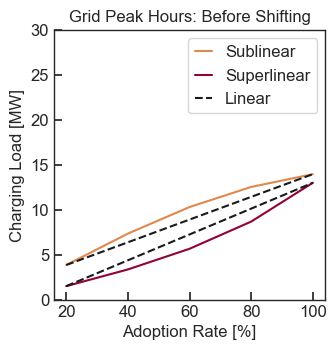

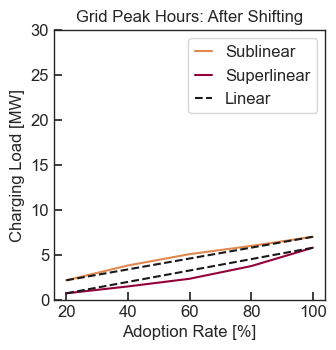

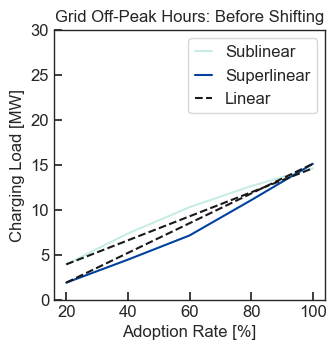

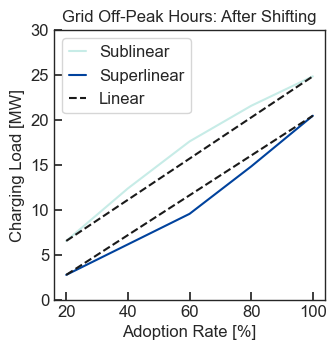

In [34]:
fig, ax = plt.subplots(figsize=(3.5,3.5))
(peak_before[peak_before['linear']==-1][[20,40,60,80,100]]).median().plot(label='Sublinear',c = '#e0884e')
(peak_before[peak_before['linear']==1][[20,40,60,80,100]]).median().plot(label='Superlinear', c= '#93003a')
y1 = (peak_before[peak_before['linear']==-1][[20]]).median()
y2 =  (peak_before[peak_before['linear']==-1][[100]]).median()
plt.plot([20,100],[y1,y2],c='k',linestyle='dashed')
y1 = (peak_before[peak_before['linear']==1][[20]]).median()
y2 =  (peak_before[peak_before['linear']==1][[100]]).median()
plt.ylim([0,30])
plt.plot([20,100],[y1,y2],c='k',linestyle='dashed',label="Linear")
plt.title("Grid Peak Hours: Before Shifting")
plt.xlabel('Adoption Rate [%]')
plt.ylabel('Charging Load [MW]')
plt.legend()
plt.savefig('figures/sp_subsuper_peak_before.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(3.5,3.5))
(peak_after[peak_after['linear']==-1][[20,40,60,80,100]]).median().plot(label='Sublinear',c = '#e0884e')
(peak_after[peak_after['linear']==1][[20,40,60,80,100]]).median().plot(label='Superlinear',c= '#93003a' ) 
y1 = (peak_after[peak_after['linear']==-1][[20]]).median()
y2 =  (peak_after[peak_after['linear']==-1][[100]]).median()
plt.plot([20,100],[y1,y2],c='k',linestyle='dashed')
y1 = (peak_after[peak_after['linear']==1][[20]]).median()
y2 =  (peak_after[peak_after['linear']==1][[100]]).median()
plt.ylim([0,30])
plt.plot([20,100],[y1,y2],c='k',linestyle='dashed',label="Linear")
plt.title("Grid Peak Hours: After Shifting")
plt.xlabel('Adoption Rate [%]')
plt.ylabel('Charging Load [MW]')
plt.legend()
plt.savefig('figures/sp_subsuper_peak_after.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(3.5,3.5))
(offpeak_before[offpeak_before['linear']==-1][[20,40,60,80,100]]).median().plot(label='Sublinear', c =  '#c7ece7')
(offpeak_before[offpeak_before['linear']==1][[20,40,60,80,100]]).median().plot(label='Superlinear', c = '#00429d')
y1 = (offpeak_before[offpeak_before['linear']==-1][[20]]).median()
y2 =  (offpeak_before[offpeak_before['linear']==-1][[100]]).median()
plt.plot([20,100],[y1,y2],c='k',linestyle='dashed')
y1 = (offpeak_before[offpeak_before['linear']==1][[20]]).median()
y2 =  (offpeak_before[offpeak_before['linear']==1][[100]]).median()
plt.ylim([0,30])
plt.plot([20,100],[y1,y2],c='k',linestyle='dashed',label="Linear")
plt.title("Grid Off-Peak Hours: Before Shifting")
plt.xlabel('Adoption Rate [%]')
plt.ylabel('Charging Load [MW]')
plt.legend()
plt.savefig('figures/sp_subsuper_offpeak_before.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(3.5,3.5))
(offpeak_after[offpeak_after['linear']==-1][[20,40,60,80,100]]).median().plot(label='Sublinear', c = '#c7ece7')
(offpeak_after[offpeak_after['linear']==1][[20,40,60,80,100]]).median().plot(label='Superlinear', c = '#00429d')
y1 = (offpeak_after[offpeak_after['linear']==-1][[20]]).median()
y2 =  (offpeak_after[offpeak_after['linear']==-1][[100]]).median()
plt.plot([20,100],[y1,y2],c='k',linestyle='dashed')
y1 = (offpeak_after[offpeak_after['linear']==1][[20]]).median()
y2 =  (offpeak_after[offpeak_after['linear']==1][[100]]).median()
plt.ylim([0,30])
plt.plot([20,100],[y1,y2],c='k',linestyle='dashed',label="Linear")
plt.title("Grid Off-Peak Hours: After Shifting")
plt.xlabel('Adoption Rate [%]')
plt.ylabel('Charging Load [MW]')
plt.legend()
plt.savefig('figures/sp_subsuper_offpeak_after.pdf',format='pdf',dpi=900,transparent=True,bbox_inches='tight')
plt.show()

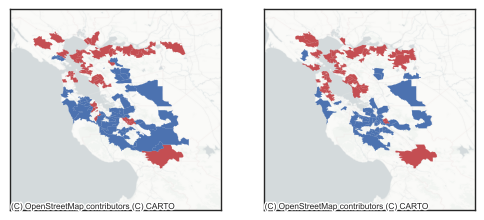

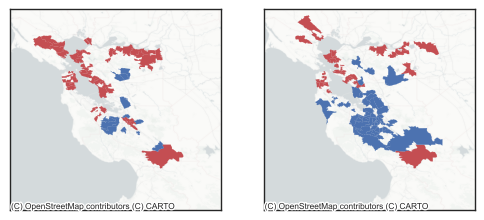

In [108]:
linear_map['zipcode'] = linear_map['zipcode'].astype(int).astype(str)
geozip = gpd.read_file("data/census/sfbay_zip.geojson")
geozip_merge = geozip.merge(linear_map,right_on='zipcode',left_on='ZCTA5CE10',how='left') 

fig, ax = plt.subplots(figsize=(6,6),nrows=1, ncols=2)

geozip_merge_sup = geozip_merge[geozip_merge['peak_before']>0]
ax[0] = geozip_merge_sup.plot(ax = ax[0], legend=False, edgecolor="face", linewidth=0.1, color = 'r')
geozip_merge_sub = geozip_merge[geozip_merge['peak_before']<0]
ax[0] = geozip_merge_sub.plot(ax = ax[0], legend=False, edgecolor="face", linewidth=0.1, color = 'b')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlim(-123, -121)
ax[0].set_ylim(36.5, 38.4)
cx.add_basemap(ax[0], source=cx.providers.CartoDB.PositronNoLabels, crs=geozip_merge.crs,attribution_size=6)

geozip_merge_sup = geozip_merge[geozip_merge['offpeak_before']>0]
ax[1] = geozip_merge_sup.plot(ax = ax[1], legend=False, edgecolor="face", linewidth=0.1, color = 'r')
geozip_merge_sub = geozip_merge[geozip_merge['offpeak_before']<0]
ax[1] = geozip_merge_sub.plot(ax = ax[1], legend=False, edgecolor="face", linewidth=0.1, color = 'b')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlim(-123, -121)
ax[1].set_ylim(36.5, 38.4)
cx.add_basemap(ax[1], source=cx.providers.CartoDB.PositronNoLabels, crs=geozip_merge.crs,attribution_size=6)
plt.savefig('figures/sp_geo_linear_peak.pdf',dpi=900,transparent=True, bbox_inches='tight')
plt.show()

linear_map['zipcode'] = linear_map['zipcode'].astype(int).astype(str)
geozip = gpd.read_file("data/census/sfbay_zip.geojson")
geozip_merge = geozip.merge(linear_map,right_on='zipcode',left_on='ZCTA5CE10',how='left') 
fig, ax = plt.subplots(figsize=(6,6),nrows=1, ncols=2)

geozip_merge_sup = geozip_merge[geozip_merge['peak_after']>0]
ax[0] = geozip_merge_sup.plot(ax = ax[0], legend=False, edgecolor="face", linewidth=0.1, color = 'r')
geozip_merge_sub = geozip_merge[geozip_merge['peak_after']<0]
ax[0] = geozip_merge_sub.plot(ax = ax[0], legend=False, edgecolor="face", linewidth=0.1, color = 'b')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlim(-123, -121)
ax[0].set_ylim(36.5, 38.4)
cx.add_basemap(ax[0], source=cx.providers.CartoDB.PositronNoLabels, crs=geozip_merge.crs,attribution_size=6)

geozip_merge_sup = geozip_merge[geozip_merge['offpeak_after']>0]
ax[1] = geozip_merge_sup.plot(ax = ax[1], legend=False, edgecolor="face", linewidth=0.1, color = 'r')
geozip_merge_sub = geozip_merge[geozip_merge['offpeak_after']<0]
ax[1] = geozip_merge_sub.plot(ax = ax[1], legend=False, edgecolor="face", linewidth=0.1, color = 'b')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlim(-123, -121)
ax[1].set_ylim(36.5, 38.4)
cx.add_basemap(ax[1], source=cx.providers.CartoDB.PositronNoLabels, crs=geozip_merge.crs,attribution_size=6)
plt.savefig('figures/sp_geo_linear_offpeak.pdf',dpi=900,transparent=True, bbox_inches='tight')
plt.show()

# 5. Print Numbers 

In [5]:
# abstract and discussion 
peak_start = 17; peak_end=21
week_peak = []; week_offpeak = []; weekend = []; 
for hour in range(168):
    if hour<24*5:
        if (hour%24 >= peak_start) and (hour%24 < peak_end):
            week_peak.append(hour)
        else:
            week_offpeak.append(hour)
    else:
        weekend.append(hour)

year = 0.5 ;mode = 1
df_user_session = pd.read_csv('results/simulated_session_update_'+str(mode)+'.csv')
df_shift_session = pd.read_csv('results/simulated_session_shift_'+str(mode)+'.csv')

user_select = pickle.load(open('results/selected_EV_Drivers_' + str(year) + 'p.pkl', 'rb'), encoding='bytes')
df_before = df_user_session[df_user_session['id'].isin(user_select)]
df_after = df_shift_session[df_shift_session['id'].isin(user_select)]

df_before = df_before.fillna(-1)
df_after = df_after.fillna(-1)
df_before = pd.pivot_table(df_before,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()
df_after = pd.pivot_table(df_after,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()
zipcode_list = df_before['stay_zipcode'].unique()
home_load, work_load, other_load, total_load = simEVLoad(df_before)
homes_load, works_load, others_load, totals_load = simEVLoad(df_after)

week_peak_total = total_load.values[:,week_peak]
week_offpeak_total = total_load.values[:,week_offpeak]
week_peak_totals = totals_load.values[:,week_peak]
week_offpeak_totals = totals_load.values[:,week_offpeak]

print((np.max(np.sum(week_peak_total,axis=0)))/1000)
print((np.max(np.sum(week_offpeak_total,axis=0)))/1000)

2295.1254000000476
2366.689800000021


In [26]:
print((np.sum(np.sum(total_load,axis=0)))/1000000)
print(209/1093.24)

209.22323060000073
0.19117485639017964


In [7]:
# secrion 2
demand_supply = pd.read_csv('results/demand.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==2]
print('week_peak_before mean',np.mean(demand_supply_results['week_peak_before']))
print('week_peak_before std',np.std(demand_supply_results['week_peak_before']))
print('week_offpeak_before mean',np.mean(demand_supply_results['week_offpeak_before']))
print('week_offpeak_before std',np.std(demand_supply_results['week_offpeak_before']))

week_peak_before mean 316.1923076923075
week_peak_before std 290.771132661377
week_offpeak_before mean 344.9890109890112
week_offpeak_before std 269.019271931307


In [8]:
# section 3
info = pd.read_csv('data/supply/usage_type.csv')
geozip = gpd.read_file("data/census/sfbay_zip.geojson")
geocs = gpd.read_file("data/supply/evcs.geojson")
geocs['UsageTypeID'] = geocs['UsageTypeID'].astype(int)
geocs = geocs.merge(info,left_on='UsageTypeID',right_on='ID')
evcs_sfbay = gpd.sjoin(geozip,geocs,how="inner")
evcs_sfbay['Power'] = evcs_sfbay['PowerKW'] * evcs_sfbay['Quantity']
evcs_sfbay = evcs_sfbay[evcs_sfbay['StationType']=='Public Charging Places']
evcs_sfbay_power = pd.pivot_table(evcs_sfbay, values='Power', index=['ZCTA5CE10'],aggfunc=np.sum)
evcs_sfbay_count = pd.pivot_table(evcs_sfbay, values='UUID', columns='StationType',aggfunc=np.count_nonzero)
geocs = geocs[geocs['UUID'].isin(evcs_sfbay['UUID'].unique())]
geocs['Power'] = geocs['PowerKW'] * geocs['Quantity']/1000
evcs_sfbay_vis = pd.pivot_table(evcs_sfbay, values='Quantity', index=['ZCTA5CE10'],aggfunc=np.sum)
evcs_sfbay_vis = evcs_sfbay_vis.reset_index()
geozip = gpd.read_file("data/census/sfbay_zip.geojson")
geozip_merge = geozip.merge(evcs_sfbay_vis,right_on='ZCTA5CE10',left_on='ZCTA5CE10', how='left')
charger_data = geozip_merge[['Quantity','ZCTA5CE10']]
charger_data['Quantity'].max()

454.0

In [9]:
# section 3
peak_start = 17; peak_end=21
week_peak = []; week_offpeak = []; weekend = []; 
for hour in range(168):
    if hour<24*5:
        if (hour%24 >= peak_start) and (hour%24 < peak_end):
            week_peak.append(hour)
        else:
            week_offpeak.append(hour)
    else:
        weekend.append(hour)

year = 0;mode = 1
df_user_session = pd.read_csv('results/simulated_session_update_'+str(mode)+'.csv')
df_shift_session = pd.read_csv('results/simulated_session_shift_'+str(mode)+'.csv')

user_select = pickle.load(open('results/selected_EV_Drivers_' + str(year) + 'p.pkl', 'rb'), encoding='bytes')
df_before = df_user_session[df_user_session['id'].isin(user_select)]
df_after = df_shift_session[df_shift_session['id'].isin(user_select)]

df_before = df_before.fillna(-1)
df_after = df_after.fillna(-1)
df_before = pd.pivot_table(df_before,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()
df_after = pd.pivot_table(df_after,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()
zipcode_list = df_before['stay_zipcode'].unique()
home_load, work_load, other_load, total_load = simEVLoad(df_before)
homes_load, works_load, others_load, totals_load = simEVLoad(df_after)

week_peak_total = total_load.values[:,week_peak]
week_offpeak_total = total_load.values[:,week_offpeak]

week_peak_totals = totals_load.values[:,week_peak]
week_offpeak_totals = totals_load.values[:,week_offpeak]

print("total")

print((np.max(np.sum(week_peak_total,axis=0))-np.max(np.sum(week_peak_totals,axis=0)))/1000)
print((np.max(np.sum(week_offpeak_total,axis=0))-np.max(np.sum(week_offpeak_totals,axis=0)))/1000)

print((np.max(np.sum(week_peak_total,axis=0))-np.max(np.sum(week_peak_totals,axis=0)))/np.max(np.sum(week_peak_total,axis=0)))
print((np.max(np.sum(week_offpeak_total,axis=0))-np.max(np.sum(week_offpeak_totals,axis=0)))/np.max(np.sum(week_offpeak_total,axis=0)))

week_peak_total = home_load.values[:,week_peak]
week_offpeak_total = home_load.values[:,week_offpeak]

week_peak_totals = homes_load.values[:,week_peak]
week_offpeak_totals = homes_load.values[:,week_offpeak]

print("home")

print((np.max(np.sum(week_peak_total,axis=0))-np.max(np.sum(week_peak_totals,axis=0)))/1000)
print((np.max(np.sum(week_offpeak_total,axis=0))-np.max(np.sum(week_offpeak_totals,axis=0)))/1000)

print((np.max(np.sum(week_peak_total,axis=0))-np.max(np.sum(week_peak_totals,axis=0)))/np.max(np.sum(week_peak_total,axis=0)))
print((np.max(np.sum(week_offpeak_total,axis=0))-np.max(np.sum(week_offpeak_totals,axis=0)))/np.max(np.sum(week_offpeak_total,axis=0)))

week_peak_total = work_load.values[:,week_peak]
week_offpeak_total = work_load.values[:,week_offpeak]

week_peak_totals = works_load.values[:,week_peak]
week_offpeak_totals = works_load.values[:,week_offpeak]

print("work")

print((np.max(np.sum(week_peak_total,axis=0))-np.max(np.sum(week_peak_totals,axis=0)))/1000)
print((np.max(np.sum(week_offpeak_total,axis=0))-np.max(np.sum(week_offpeak_totals,axis=0)))/1000)

print((np.max(np.sum(week_peak_total,axis=0))-np.max(np.sum(week_peak_totals,axis=0)))/np.max(np.sum(week_peak_total,axis=0)))
print((np.max(np.sum(week_offpeak_total,axis=0))-np.max(np.sum(week_offpeak_totals,axis=0)))/np.max(np.sum(week_offpeak_total,axis=0)))

week_peak_total = other_load.values[:,week_peak]
week_offpeak_total = other_load.values[:,week_offpeak]

week_peak_totals = others_load.values[:,week_peak]
week_offpeak_totals = others_load.values[:,week_offpeak]

print("other")
print((np.max(np.sum(week_peak_total,axis=0))-np.max(np.sum(week_peak_totals,axis=0)))/1000)
print((np.max(np.sum(week_offpeak_total,axis=0))-np.max(np.sum(week_offpeak_totals,axis=0)))/1000)

print((np.max(np.sum(week_peak_total,axis=0))-np.max(np.sum(week_peak_totals,axis=0)))/np.max(np.sum(week_peak_total,axis=0)))
print((np.max(np.sum(week_offpeak_total,axis=0))-np.max(np.sum(week_offpeak_totals,axis=0)))/np.max(np.sum(week_offpeak_total,axis=0)))

total
37.3958
-47.49480000000002
0.6403302694483637
-0.8427638583291933
home
20.925000000000008
9.341400000000002
0.6343792633015007
0.3447290923986449
work
1.8149999999999995
-7.517400000000008
0.5600814663951119
-0.27719639815040187
other
16.572599999999987
-37.93400000000001
0.6395575897439854
-1.6532289696409752


In [42]:
print(20.925000000000008/37.3958)
print(7.517400000000008/47.49480000000002)
print(16.572599999999987/37.3958)
print(37.93400000000001/47.49480000000002)

0.559554816316271
0.15827837994896293
0.44316741452248615
0.7986979627243402


In [10]:
# section 3
demand_supply = pd.read_csv('results/supply.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==2]
print('reduction: peak',np.mean(demand_supply_results['week_peak_after_gap']-demand_supply_results['week_peak_before_gap']))
print('increase off-peak',np.mean(demand_supply_results['week_offpeak_after_gap']-demand_supply_results['week_offpeak_before_gap']))

print('offpeak_before',len(demand_supply_results[demand_supply_results['week_offpeak_before_gap']<0]))
print('peak_before',len(demand_supply_results[demand_supply_results['week_peak_before_gap']<0]))
print('offpeak_after',len(demand_supply_results[demand_supply_results['week_offpeak_after_gap']<0]))
print('peak_after',len(demand_supply_results[demand_supply_results['week_peak_after_gap']<0]))

print(np.mean(demand_supply_results['week_peak_after_gap']))
print(np.mean(demand_supply_results['week_offpeak_after_gap']))

print(np.sum(demand_supply_results['week_peak_after_gap']))
print(np.sum(demand_supply_results['week_offpeak_after_gap']))

print(np.sum(demand_supply_results['week_peak_before_gap']))
print(np.sum(demand_supply_results['week_offpeak_before_gap']))


reduction: peak 82.4736263736264
increase off-peak -249.53186813186832
offpeak_before 60
peak_before 64
offpeak_after 113
peak_after 33
757.7807692307689
437.37967032966975
137916.1
79603.1
122905.90000000002
125017.9


In [11]:
# section 3: how many shift?
df_shift_session = pd.read_csv('results/simulated_session_shift_'+str(mode)+'.csv')
df_shift_total = df_shift_session[df_shift_session['is_shift']==1]
print('cross-shift-ratio:',len(df_shift_total[(df_shift_total['session_type']!=df_shift_total['original_session_type'])])/len(df_shift_total))

df_shift_home = df_shift_total[df_shift_total['original_session_type'].isin(['home_l1','home_l2','mud_l2'])]
print('home',len(df_shift_home))
print('home-home:',len(df_shift_home[df_shift_home['session_type'].isin(['home_l1','home_l2','mud_l2'])]))
print('home-work:',len(df_shift_home[df_shift_home['session_type'].isin(['work_l2'])]))
print('home-public:',len(df_shift_home[df_shift_home['session_type'].isin(['public_l2','public_l3'])]))

df_shift_work = df_shift_total[df_shift_total['original_session_type'].isin(['work_l2'])]
print('work',len(df_shift_work))
print('work-work:',len(df_shift_work[df_shift_work['session_type'].isin(['work_l2'])]))
print('work-home:',len(df_shift_work[df_shift_work['session_type'].isin(['home_l1','home_l2','mud_l2'])]))
print('work-public:',len(df_shift_work[df_shift_work['session_type'].isin(['public_l2','public_l3'])]))

df_shift_public = df_shift_total[df_shift_total['original_session_type'].isin(['public_l2','public_l3'])]
print('public',len(df_shift_public))
print('public-public:',len(df_shift_public[df_shift_public['session_type'].isin(['public_l2','public_l3'])]))
print('public-work:',len(df_shift_public[df_shift_public['session_type'].isin(['work_l2'])]))
print('public-home:',len(df_shift_public[df_shift_public['session_type'].isin(['home_l1','home_l2','mud_l2'])]))

cross-shift-ratio: 0.5573822301180383
home 675349
home-home: 0
home-work: 119563
home-public: 555786
work 26375
work-work: 0
work-home: 11505
work-public: 14870
public 601920
public-public: 577016
public-work: 11164
public-home: 13740


In [12]:
# section 4
demand_supply = pd.read_csv('results/demand.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==20]
print('20 peak before dif',np.mean((demand_supply_results['week_peak_after']-demand_supply_results['week_peak_before'])/demand_supply_results['week_peak_before']))
print('20 peak after dif',np.mean(demand_supply_results['week_peak_after']-demand_supply_results['week_peak_before']))

demand_supply = pd.read_csv('results/demand.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==100]
print('100 peak before dif',np.mean((demand_supply_results['week_peak_after']-demand_supply_results['week_peak_before'])/demand_supply_results['week_peak_before']))
print('100 peak after dif',np.mean(demand_supply_results['week_peak_after']-demand_supply_results['week_peak_before']))

demand_supply = pd.read_csv('results/demand.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==20]
print('20 offpeak before dif',np.mean((demand_supply_results['week_offpeak_after']-demand_supply_results['week_offpeak_before'])/demand_supply_results['week_offpeak_before']))
print('20 offpeak after dif',np.mean(demand_supply_results['week_offpeak_after']-demand_supply_results['week_offpeak_before']))

demand_supply = pd.read_csv('results/demand.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==100]
print('100 offpeak before dif',np.mean((demand_supply_results['week_offpeak_after']-demand_supply_results['week_offpeak_before'])/demand_supply_results['week_offpeak_before']))
print('100 offpeak after dif',np.mean(demand_supply_results['week_offpeak_after']-demand_supply_results['week_offpeak_before']))

20 peak before dif -0.5827216706338502
20 peak after dif -1601.6043956043898
100 peak before dif -0.5614367578749931
100 peak after dif -7661.15824175843
20 offpeak before dif 0.6288105386067014
20 offpeak after dif 1923.0956043955978
100 offpeak before dif 0.462404933912397
100 offpeak after dif 7648.262637362649


In [13]:
# section 4
thres = 0.3
demand_supply = pd.read_csv('results/demand.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==20]
demand_supply_results['reduce_ratio'] = (demand_supply_results['week_peak_before']-demand_supply_results['week_peak_after'])/demand_supply_results['week_peak_before']
print(len(demand_supply_results[demand_supply_results['reduce_ratio']>thres]))

demand_supply = pd.read_csv('results/demand.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==100]
demand_supply_results['reduce_ratio'] = (demand_supply_results['week_peak_before']-demand_supply_results['week_peak_after'])/demand_supply_results['week_peak_before']
print(len(demand_supply_results[demand_supply_results['reduce_ratio']>thres]))

thres = 0.3
demand_supply = pd.read_csv('results/demand.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==20]
demand_supply_results['reduce_ratio'] = (demand_supply_results['week_offpeak_after']-demand_supply_results['week_offpeak_before'])/demand_supply_results['week_offpeak_before']
print(len(demand_supply_results[demand_supply_results['reduce_ratio']>thres]))

demand_supply = pd.read_csv('results/demand.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==100]
demand_supply_results['reduce_ratio'] = (demand_supply_results['week_offpeak_after']-demand_supply_results['week_offpeak_before'])/demand_supply_results['week_offpeak_before']
print(len(demand_supply_results[demand_supply_results['reduce_ratio']>thres]))

175
178
152
145


In [14]:
# section 4: demand change
demand_supply = pd.read_csv('results/demand.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==20]
demand_supply_results['reduce_value'] = (demand_supply_results['week_peak_before']-demand_supply_results['week_peak_after'])
print(demand_supply_results['reduce_value'].mean())

demand_supply = pd.read_csv('results/demand.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==100]
demand_supply_results['reduce_value'] = (demand_supply_results['week_peak_before']-demand_supply_results['week_peak_after'])
print(demand_supply_results['reduce_value'].mean())

demand_supply = pd.read_csv('results/demand.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==20]
demand_supply_results['increase_value'] = (demand_supply_results['week_offpeak_after']-demand_supply_results['week_offpeak_before'])
print(demand_supply_results['increase_value'].mean())

demand_supply = pd.read_csv('results/demand.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==100]
demand_supply_results['increase_value'] = (demand_supply_results['week_offpeak_after']-demand_supply_results['week_offpeak_before'])
print(demand_supply_results['increase_value'].mean())

1601.6043956043898
7661.15824175843
1923.0956043955978
7648.262637362649


In [22]:
# section 3
node_label = ['Home: Before', 'Work: Before', 'Public: Before', 'Home: After', 'Work: After', 'Public: After']
node_dict = {y:x for x, y in enumerate(node_label)}
source = ['Home: Before','Home: Before','Home: Before','Work: Before','Work: Before','Work: Before','Public: Before','Public: Before','Public: Before']
target = ['Home: After','Work: After','Public: After','Home: After','Work: After','Public: After','Home: After','Work: After','Public: After'] 
values = [0, 119563/675349, 555786/675349, 11505/26375, 0, 14870/26375, 13740/601920, 11164/601920, 577016/601920]
source_node = [node_dict[x] for x in source]
target_node = [node_dict[x] for x in target]

fig = go.Figure( 
    data=[go.Sankey( # The plot we are interest
        # This part is for the node information
        arrangement = "snap",
        node = dict( 
            label = node_label,
            x = [0.1,0.1,0.1,0.7,0.7,0.7],
            y = [0.1,0.2,0.3,0.1,0.2,0.3]
        ),
        # This part is for the link information
        link = dict(
            source = source_node,
            target = target_node,
            value = values
        ))])
fig.show()
fig.write_image('figures/fig3_sanky.pdf')

In [31]:
# section 4
print("===============on-peak===============")

demand_supply = pd.read_csv('results/supply.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==20]
print("20 peak_before_gap",len(demand_supply_results[demand_supply_results['week_peak_before_gap']<0])/len(demand_supply_results))
print('mean',demand_supply_results['week_peak_before_gap'].mean())
print('std',demand_supply_results['week_peak_before_gap'].std())
print('num',demand_supply_results['week_peak_before_gap'].mean()/50)

demand_supply = pd.read_csv('results/supply.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==100]
print("100 peak_before_gap",len(demand_supply_results[demand_supply_results['week_peak_before_gap']<0])/len(demand_supply_results))
print('mean',demand_supply_results['week_peak_before_gap'].mean())
print('std',demand_supply_results['week_peak_before_gap'].std())
print('num',demand_supply_results['week_peak_before_gap'].mean()/50)
print("==============================")

demand_supply = pd.read_csv('results/supply.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==20]
print("20 peak_after_gap", len(demand_supply_results[demand_supply_results['week_peak_after_gap']<0])/len(demand_supply_results))
print('mean',demand_supply_results['week_peak_after_gap'].mean())
print('std',demand_supply_results['week_peak_after_gap'].std())
print('num',demand_supply_results['week_peak_after_gap'].mean()/50)

demand_supply = pd.read_csv('results/supply.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==100]
print("100 peak_after_gap", len(demand_supply_results[demand_supply_results['week_peak_after_gap']<0])/len(demand_supply_results))
print('mean',demand_supply_results['week_peak_after_gap'].mean())
print('std',demand_supply_results['week_peak_after_gap'].std())
print('num',demand_supply_results['week_peak_after_gap'].mean()/50)

print("============off-peak==================")

demand_supply = pd.read_csv('results/supply.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==20]
print("offpeak_before_gap",len(demand_supply_results[demand_supply_results['week_offpeak_before_gap']<0])/len(demand_supply_results))
print('mean',demand_supply_results['week_offpeak_before_gap'].mean())
print('std',demand_supply_results['week_offpeak_before_gap'].std())
print('num',demand_supply_results['week_offpeak_before_gap'].mean()/50)

demand_supply = pd.read_csv('results/supply.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==100]
print("offpeak_before_gap",len(demand_supply_results[demand_supply_results['week_offpeak_before_gap']<0])/len(demand_supply_results))
print('mean',demand_supply_results['week_offpeak_before_gap'].mean())
print('std',demand_supply_results['week_offpeak_before_gap'].std())
print('num',demand_supply_results['week_offpeak_before_gap'].mean()/50)

print("==============================")

demand_supply = pd.read_csv('results/supply.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==20]
print("20 offpeak_after_gap",len(demand_supply_results[demand_supply_results['week_offpeak_after_gap']<0])/len(demand_supply_results))
print('mean',demand_supply_results['week_offpeak_after_gap'].mean())
print('std',demand_supply_results['week_offpeak_after_gap'].std())
print('num',demand_supply_results['week_offpeak_after_gap'].mean()/50)

demand_supply = pd.read_csv('results/supply.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==100]
print("100 offpeak_after_gap", len(demand_supply_results[demand_supply_results['week_offpeak_after_gap']<0])/len(demand_supply_results))
print('mean',demand_supply_results['week_offpeak_after_gap'].mean())
print('std',demand_supply_results['week_offpeak_after_gap'].std())
print('num',demand_supply_results['week_offpeak_after_gap'].mean()/50)

===============on-peak===============
20 peak_before_gap 0.7252747252747253
mean -395.2247252747211
std 1194.1311375618145
num -7.904494505494422
100 peak_before_gap 0.9615384615384616
mean -6506.439010989159
std 4823.35252649851
num -130.12878021978318
20 peak_after_gap 0.6208791208791209
mean 351.52142857142786
std 1196.9464402885765
num 7.0304285714285575
100 peak_after_gap 0.9175824175824175
mean -2185.8543956043995
std 1973.3152032390167
num -43.71708791208799
============off-peak==================
offpeak_before_gap 0.7197802197802198
mean -254.43901098900847
std 1171.9797871114981
num -5.088780219780169
offpeak_before_gap 0.9560439560439561
mean -5700.1500000001315
std 4113.448664415317
num -114.00300000000263
20 offpeak_after_gap 0.8791208791208791
mean -1964.5445054944998
std 1905.4326775199345
num -39.29089010989
100 offpeak_after_gap 0.967032967032967
mean -11839.182967033097
std 8432.429776026009
num -236.78365934066196


In [32]:
# section 4: net change
demand_supply = pd.read_csv('results/supply.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==20]
demand_supply_results['demand_before'] = demand_supply_results[['week_peak_before', 'week_offpeak_before']].max(axis=1)
demand_supply_results['demand_after'] = demand_supply_results[['week_peak_after', 'week_offpeak_after']].max(axis=1)
print('before_gap',(demand_supply_results['demand_before']-demand_supply_results['Power']).mean())
print('after_gap',(demand_supply_results['demand_after']-demand_supply_results['Power']).mean())
print('net_gap',(demand_supply_results['demand_after']-demand_supply_results['demand_before']).mean())
print('net_gap_num',(demand_supply_results['demand_after']-demand_supply_results['demand_before']).mean()/50)

demand_supply = pd.read_csv('results/supply.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==100]
demand_supply_results['demand_before'] = demand_supply_results[['week_peak_before', 'week_offpeak_before']].max(axis=1)
demand_supply_results['demand_after'] = demand_supply_results[['week_peak_after', 'week_offpeak_after']].max(axis=1)
print('before_gap',(demand_supply_results['demand_before']-demand_supply_results['Power']).mean())
print('after_gap',(demand_supply_results['demand_after']-demand_supply_results['Power']).mean())
print('net_gap',(demand_supply_results['demand_after']-demand_supply_results['demand_before']).mean())
print('net_gap_num',(demand_supply_results['demand_after']-demand_supply_results['demand_before']).mean()/50)

before_gap 416.9675824175783
after_gap 1964.580769230764
net_gap 1547.6131868131852
net_gap_num 30.952263736263703
before_gap 6628.409340659485
after_gap 11839.503846153975
net_gap 5211.0945054945005
net_gap_num 104.22189010989001


In [19]:
year = 0;mode = 1
df_user_session = pd.read_csv('results/simulated_session_update_'+str(mode)+'.csv')
df_shift_session = pd.read_csv('results/simulated_session_shift_'+str(mode)+'.csv')

user_select = pickle.load(open('results/selected_EV_Drivers_' + str(0.3) + 'p.pkl', 'rb'), encoding='bytes')
df_before = df_user_session[df_user_session['id'].isin(user_select)]
df_after = df_shift_session[df_shift_session['id'].isin(user_select)]

df_before = df_before.fillna(-1)
df_after = df_after.fillna(-1)
df_before = pd.pivot_table(df_before,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()
df_after = pd.pivot_table(df_after,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()
zipcode_list = df_before['stay_zipcode'].unique()
home_load, work_load, other_load, total_load = simEVLoad(df_before)
homes_load, works_load, others_load, totals_load = simEVLoad(df_after)

week_peak_total = total_load.values[:,week_peak]
week_offpeak_total = total_load.values[:,week_offpeak]
week_peak_totals = totals_load.values[:,week_peak]
week_offpeak_totals = totals_load.values[:,week_offpeak]

print(np.max(np.sum(week_peak_total,axis=0))-np.max(np.sum(week_peak_totals,axis=0)))
print(np.max(np.sum(week_offpeak_total,axis=0))-np.max(np.sum(week_offpeak_totals,axis=0)))

435273.5999999981
-496773.3999999997


In [38]:
year = 0; mode = 1
df_user_session = pd.read_csv('results/simulated_session_update_'+str(mode)+'.csv')
df_shift_session = pd.read_csv('results/simulated_session_shift_'+str(mode)+'.csv')

user_select = pickle.load(open('results/selected_EV_Drivers_' + str(0.5) + 'p.pkl', 'rb'), encoding='bytes')
df_before = df_user_session[df_user_session['id'].isin(user_select)]
df_after = df_shift_session[df_shift_session['id'].isin(user_select)]

df_before = df_before.fillna(-1)
df_after = df_after.fillna(-1)
df_before = pd.pivot_table(df_before,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()
df_after = pd.pivot_table(df_after,index=['id','arrive_time','depature_time','stay_zipcode','session_type'],values='session_energy',aggfunc=np.sum).reset_index()
zipcode_list = df_before['stay_zipcode'].unique()
home_load, work_load, other_load, total_load = simEVLoad(df_before)
homes_load, works_load, others_load, totals_load = simEVLoad(df_after)

week_peak_total = total_load.values[:,week_peak]
week_offpeak_total = total_load.values[:,week_offpeak]
week_peak_totals = totals_load.values[:,week_peak]
week_offpeak_totals = totals_load.values[:,week_offpeak]

print(  np.max(np.sum(week_peak_total,axis=0)), np.max(np.sum(week_peak_totals,axis=0)))
print( (np.max(np.sum(week_peak_total,axis=0))-np.max(np.sum(week_peak_totals,axis=0)))/np.max(np.sum(week_peak_total,axis=0)) )
print( (np.max(np.sum(week_offpeak_total,axis=0))-np.max(np.sum(week_offpeak_totals,axis=0)))/np.max(np.sum(week_offpeak_total,axis=0)) )

2295125.400000048 885426.199999993
0.6142144564301478
-0.6225830693992945


In [37]:
# section 4
demand_supply = pd.read_csv('results/supply.csv')
demand_supply_results = demand_supply[demand_supply['adoption rate']==0.5]
demand_supply_results['demand_before'] = demand_supply_results[['week_peak_before', 'week_offpeak_before']].max(axis=1)
demand_supply_results['demand_after'] = demand_supply_results[['week_peak_after', 'week_offpeak_after']].max(axis=1)
print(len(demand_supply_results[demand_supply_results['week_offpeak_after_gap']<0])/len(demand_supply_results))
print((demand_supply_results['demand_before']-demand_supply_results['Power']).mean()/50)
print((demand_supply_results['demand_after']-demand_supply_results['Power']).mean()/50)
print((demand_supply_results['demand_after']-demand_supply_results['demand_before']).mean()/50)

print((demand_supply_results['demand_after']-demand_supply_results['demand_before']).sum()/50)
print((demand_supply_results['demand_after']-demand_supply_results['Power']).sum()/50)
print((demand_supply_results['demand_before']-demand_supply_results['Power']).sum()/50)

0.9615384615384616
102.04258241758454
202.86042857143093
100.81784615384633
18348.84800000003
36920.598000000435
18571.7500000004
